# Market Influence on Tender Performance

This project had two main objectives, to study the influence of the market state on profit margins practiced by the partnering company in tender auctions and to create a decision support tool for the company managers to optimize the offered bids. For this purpose several models were tested and compared.

We were provided with real data from past tender auction results from the company that included basic information about the main characteristics of the proposals presented in auctions from past years as well as the clients in question. Several models for the problem were tested, with the main output being the probability of success and the main variables being the global margin and the market state.

To study the market impact two different approaches were tested, the explicit and the implicit. In the explicit approach we have constructed a global Market Index (MI) that reflects the overall economic situation for our specific market, that was incorporated explicitly into the model. In the implicit approach, using the technique of Hidden Markov Chains, we have created the artificial variable of the state of the market (stable or turbulent) and incorporated this binary variable into the model. We hoped that the constructed states would retain the information given by the market index and thus, when comparing the predictive performances of the models with the market index variables versus the models with the market states they would be similar. 

## Description

The company acquires business by participating and winning tenders, also known as reverse auctions or RFQ(Request For Quotation), where the companies providing a product or service make proposals and then the buyer(client) chooses which seller has presented the best offer. We studied only auctions with one phase, i.e. after the first round of proposals the client chooses automatically one of the offers.

The data received from each proposal consists of the time of the proposal, the client in question given by a ClientID variable, the global margin of the proposal K, which corresponds to the sum of three other internal variables common in the industrial and construction environment, namely, Overheads, O, Risk, R, and Profit, P. Therefore, the global margin is given by:

K = O + R + P

The first step is to create a market index variable specific to the market where the company operates

## Market Index

### Create Market Index

The index will be composed of four different economic indexes available in the EuroStat database. Then, the Market Index, MI, is obtained through principal component analysis (PCA).

In [3]:
#Mont Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/My Drive/Market_Influence'

/content/drive/My Drive/Market_Influence


In [10]:
!git clone https://github.com/brunomrpires/market_tender_preformance.git

Cloning into 'market_tender_preformance'...
fatal: could not read Username for 'https://github.com': No such device or address


In [7]:
#Importing necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
import math
#from datequarter import DateQuarter
from sklearn.metrics import classification_report
from statsmodels.discrete.discrete_model import Probit
from sklearn.svm import SVC
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import GridSearchCV
import random
from sklearn.linear_model import SGDClassifier
from scipy import optimize
import theano as thno
import theano.tensor as T
from sklearn.linear_model import LogisticRegression
import warnings
import pickle
import copy
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from mlxtend.plotting import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# Defining Market Index

#Importing data for Market Index from EuroStat platform

economic_data = pd.read_excel('/content/drive/My Drive/Market_Influence/Data/mi_data.xlsx')

#Set dates as index
economic_data = economic_data.set_index('quarter')

In [ ]:
#Principal component analysis to obtain the coefficients for each index

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(economic_data.iloc[:-1,:])

principal_Df = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2','PC3','PC4'])


# Get date list from 2006 until 2020Q2

base = datetime.datetime(2006,1,15)
date_list = [base + datetime.timedelta(days=365/4 * x) for x in range(58)]
principal_Df['quarter']=pd.PeriodIndex(date_list, freq='Q')
principal_Df = principal_Df.set_index('quarter')


# Explained variance

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.86212845 0.09416274 0.04160424 0.00210456]


In [ ]:
#The Market Index will corresponds to the first principal component which explains more than 86%
#of the variation in the data of the four indexes

components = pca.components_[0]

print(components)

#Create Market Index variable
index_values = []
date_list2 = [base + datetime.timedelta(days=365/4 * x) for x in range(59)]
for i in range(len(economic_data.iloc[:,0])):
    index_values.append(np.sum(economic_data.iloc[i,:].values*components))
market_index = pd.DataFrame({'market_index': index_values},
                            index=pd.PeriodIndex(date_list2, freq='Q'))

[0.2630753  0.4489942  0.53716731 0.66381238]


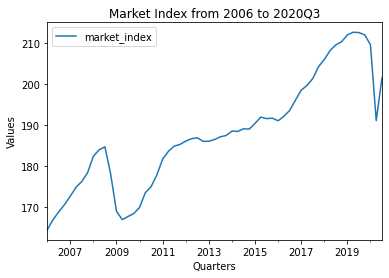

In [ ]:
#We can then plot the Market Index (MI) created

market_index.plot(title='Market Index from 2006 to 2020Q3', xlabel='Quarters', ylabel='Values')

### Estimate Market Index

To estimate future values for the MI we take a similar approach to (Ng. 2004) in 'An integrated regression analysis and time series model for construction tender price index forecasting' by using an integrated approach and combining a time series model with a regression model in order to estimate future values for the MI. The regression and time series models will be constructed on the observations until 2020Q2 with the last observation 2020Q3 being left alone

#### Regression Model

We obtain several other economic indicators from the EuroStat platform to include in the regression model. Not onlt do we need to consider the obtained variables but also their lagged (1,2 and 3 quarters) counterparts because there might be some lagged influence from the economic indicators in our market index.

In [ ]:
#Importing data for Market Index estimation (explanatory variables for the regression model)

explanatory_data = pd.read_excel('/content/drive/My Drive/Market_Influence/Data/explanatory_data.xlsx')
for i in range(len(explanatory_data['quarter'])):
    explanatory_data['quarter'][i] = explanatory_data['quarter'][i].to_period(freq= 'Q')
#Set dates as index
explanatory_data = explanatory_data.set_index('quarter')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#Create shiftted variables to include in the linear regression estimation
explanatory_data1 = explanatory_data.shift(1)
explanatory_data1.columns = ['un_rate1',
                            'gdp_index1',
                            'serv_price_index1',
                            'prod_serv_index1',
                            'prod_cons_index1',
                            'lab_inp_index1',
                            'int_rates1',
                            'prod_ind_index1']
exp_data = explanatory_data
exp_data = exp_data.merge(explanatory_data1, how = 'left', left_index = True, right_index = True)
explanatory_data2 = explanatory_data.shift(2)
explanatory_data2.columns = ['un_rate2',
                                        'gdp_index2',
                                        'serv_price_index2',
                                        'prod_serv_index2',
                                        'prod_cons_index2',
                                        'lab_inp_index2',
                                        'int_rates2',
                                        'prod_ind_index2']
exp_data = exp_data.merge(explanatory_data2, how = 'left', left_index = True, right_index = True)
explanatory_data3 = explanatory_data.shift(3)
explanatory_data3.columns = ['un_rate3',
                                        'gdp_index3',
                                        'serv_price_index3',
                                        'prod_serv_index3',
                                        'prod_cons_index3',
                                        'lab_inp_index3',
                                        'int_rates3',
                                        'prod_ind_index3']
exp_data = exp_data.merge(explanatory_data3, how = 'left', left_index = True, right_index = True)
exp_data = exp_data['2006Q4':]

# Create final dataset with dependent variable market_index and all the shifted variables
# The dataset now begins in 2006Q4 because the n-shiftted variables don't have the first n values

exp_data['market_index'] = market_index.iloc[3:].values

The process of selecting the relevant variables for the regression model is done through a stepwise selection algorithm with some adjustments where, after selecting a given variable, the associated lagged variables can no longer be added to the model.

In [ ]:
#We need to create a Stepwise forward selection function that after adding a given variables discards all the related lagged variables

#Function to remove lagged featureas after one of the variants has been chosen for the RA model


def remove_lags(excluded, feature):
    result = excluded
    if feature[-1] == '1':
        temp = [feature[:-1], feature[:-1]+'2',feature[:-1]+'3']
        for i in range(len(temp)):
            result.remove(temp[i])
    elif feature[-1] == '2':
        temp = [feature[:-1], feature[:-1]+'1',feature[:-1]+'3']
        for i in range(len(temp)):
            result.remove(temp[i])
    elif feature[-1] == '3':
        temp = [feature[:-1], feature[:-1]+'1',feature[:-1]+'2']
        for i in range(len(temp)):
            result.remove(temp[i])
    else:
        temp = [feature+'1', feature+'2',feature+'3']
        for i in range(len(temp)):
            result.remove(temp[i])
    return result

def add_lags(excluded, feature):
    result = excluded
    if feature[-1] == '1':
        temp = [feature[:-1], feature[:-1]+'2',feature[:-1]+'3']
        for i in range(len(temp)):
            result.append(temp[i])
    elif feature[-1] == '2':
        temp = [feature[:-1], feature[:-1]+'1',feature[:-1]+'3']
        for i in range(len(temp)):
            result.append(temp[i])
    elif feature[-1] == '3':
        temp = [feature[:-1], feature[:-1]+'1',feature[:-1]+'2']
        for i in range(len(temp)):
            result.append(temp[i])
    else:
        temp = [feature+'1', feature+'2',feature+'3']
        for i in range(len(temp)):
            result.append(temp[i])
    return result


def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Returns: list of selected features 
    """
    included = list(initial_list)
    temp = X.columns
    while True:
        changed=False
        # forward step
        excluded = list(set(temp)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            temp = remove_lags(excluded, best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            temp = add_lags(excluded, best_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
warnings.filterwarnings("ignore")

selected_features = stepwise_selection(exp_data.iloc[:55,:32], 
                                       exp_data['market_index'].iloc[:55])

Add  prod_serv_index                with p-value 7.64704e-39
Add  serv_price_index               with p-value 0.00240685
Add  lab_inp_index3                 with p-value 2.04594e-06
Add  int_rates3                     with p-value 1.15731e-06
Add  prod_cons_index                with p-value 0.0022537
Add  gdp_index                      with p-value 0.00404022


After Performing the feature selection we end up with the following features:

In [ ]:
#The relevant features for the RA model are the following
selected_features = ['prod_serv_index','serv_price_index','lab_inp_index3','int_rates3','prod_cons_index','gdp_index']
#We also need to include the non lagged version of the lagged variables
important_features = selected_features + ['lab_inp_index','int_rates']

#Compute the regression model with the following code
'''
reg_model = sm.OLS(exp_data['market_index'].iloc[:55], 
                   sm.add_constant(pd.DataFrame(exp_data.iloc[:55,:32][selected_features]))).fit()

'''
#Import the obtained model

reg_model = pickle.load(open('/content/drive/My Drive/Market_Influence/Models/reg_model.sav','rb'))

After finding the statistically significant variables, the next step concerns the predictions of those variables for future quarters. In order to predict each feature, the best fit ARIMA model is fitted, however, before fitting the time series model we need to perform the Ad-Fuller test to check the series stationarity and apply some transformations to the series until stationarity is achieved. The transformations range from applying the log-transform to the series to using the differences between previous and current values.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# The selected features were:
#'prod_serv_index',
#'serv_price_index',
#'lab_inp_index3',
#'int_rates3',
#'prod_cons_index',
#'gdp_index'

#With the Ad-Fuller, at a 10% significance level, if the obtained p-value is smaller than 10% then we reject the null hypotesis
#and infer that the series is stationary


#__________prod_serv_index

adf_result = adfuller(exp_data['prod_serv_index'][:55])

print('ADF Statistic: %f' % adf_result[0])
print('p_value: %f' % adf_result[1])
print('Critical values:')

for key,value in adf_result[4].items():
    print('\t%s: %.3f' % (key,value))
    
print('There is stationarity at a 10% significance level\n')


#__________serv_price_index

dif_serv_price_index= exp_data['serv_price_index'][:55] - exp_data['serv_price_index'][:55].shift(1)
dif_serv_price_index = dif_serv_price_index.dropna()


adf_result = adfuller(dif_serv_price_index)

print('ADF Statistic: %f' % adf_result[0])
print('p_value: %f' % adf_result[1])
print('Critical values:')

for key,value in adf_result[4].items():
    print('\t%s: %.3f' % (key,value))
    
print('There is stationarity at a 10% significance level\n')
    
#__________lab_inp_index3

dif_log_lab_inp_index3= np.log(exp_data['lab_inp_index3'][:55]) - np.log(exp_data['lab_inp_index3'][:55].shift(1))
dif_log_lab_inp_index3 = dif_log_lab_inp_index3.dropna()


adf_result = adfuller(dif_log_lab_inp_index3)

print('ADF Statistic: %f' % adf_result[0])
print('p_value: %f' % adf_result[1])
print('Critical values:')

for key,value in adf_result[4].items():
    print('\t%s: %.3f' % (key,value))

print('There is stationarity at a 10% significance level\n')

#__________int_rates3

adf_result = adfuller(exp_data['int_rates3'][:55])

print('ADF Statistic: %f' % adf_result[0])
print('p_value: %f' % adf_result[1])
print('Critical values:')

for key,value in adf_result[4].items():
    print('\t%s: %.3f' % (key,value))
    
print('There is stationarity at a 10% significance level\n')

#__________prod_cons_index

dif_prod_cons_index= exp_data['prod_cons_index'][:55] - exp_data['prod_cons_index'][:55].shift(1)
dif_prod_cons_index = dif_prod_cons_index.dropna()


adf_result = adfuller(dif_prod_cons_index)

print('ADF Statistic: %f' % adf_result[0])
print('p_value: %f' % adf_result[1])
print('Critical values:')

for key,value in adf_result[4].items():
    print('\t%s: %.3f' % (key,value))
    
print('There is stationarity at a 10% significance level\n')


#__________gdp_index

adf_result = adfuller(exp_data['gdp_index'][:55])

print('ADF Statistic: %f' % adf_result[0])
print('p_value: %f' % adf_result[1])
print('Critical values:')

for key,value in adf_result[4].items():
    print('\t%s: %.3f' % (key,value))
    
print('There is stationarity at a 10% significance level\n')

ADF Statistic: -2.882596
p_value: 0.047410
Critical values:
	1%: -3.560
	5%: -2.918
	10%: -2.597
There is stationarity at a 10% significance level

ADF Statistic: -4.851794
p_value: 0.000043
Critical values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
There is stationarity at a 10% significance level

ADF Statistic: -2.720709
p_value: 0.070523
Critical values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
There is stationarity at a 10% significance level

ADF Statistic: -14.668147
p_value: 0.000000
Critical values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
There is stationarity at a 10% significance level

ADF Statistic: -6.486101
p_value: 0.000000
Critical values:
	1%: -3.560
	5%: -2.918
	10%: -2.597
There is stationarity at a 10% significance level

ADF Statistic: -3.791248
p_value: 0.002998
Critical values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
There is stationarity at a 10% significance level



Now we have all the stationary series for the significant explanatory variables of the regression model and thus we can now focus on predicting the future values of this variables by fitting the best ARIMA model in each case. Through a gridsearch approach we find the best models for every single variable

In [ ]:
# GridSearch hyperparameters on ARIMA model
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = np.sqrt(mse(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

After applying the previous gridsearch for every variable we have the following ARIMA models:

'prod_serv_index' = ARIMA(0,2,0)

'serv_price_index' = ARIMA(3,0,1)

'lab_inp_index3' = ARIMA(3,0,0)

'int_rates3' = ARIMA(1,1,0)

'prod_cons_index' = ARIMA(2,1,0)

'gdp_index = ARIMA(0,2,0)


Additionally we can also summarized the transformations we applied to each of the series the guarantee stationarity:

'prod_serv_index' = (None, 0)

'serv_price_index' = (None, 1)

'lab_inp_index3' = (Log, 1)

'int_rates3' = (None, 0)

'prod_cons_index' = (None, 1)

'gdp_index' = (None, 0)

Where the first component indicates if the log-transformation was applied and the second component indicates the amount of differencing steps performed

In [ ]:
#%% Now we have all the ARIMA models for all the explanatory variables of the
# RA model and thus we can use that model with this predictions to predict market_index

# In some of the models the predictions are of transformations and thus we need
#to perform the inverse transformation

# First we need to define a function that does 1-step predictions of the given TS
# We can adpat the code from the evaluate_arima_model function
# If the feature is lagged then we don't need to perform 1-step predictions 

def step_evaluation(dataset, transf, order, lag, name):
    if lag == 0:
        #prepare training dataset
        train_size = int(len(dataset)*0.66)
        train, test = dataset[0:train_size], dataset[train_size:]
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0][0]
            predictions.append(yhat)
            history.append(test[t])
        #Calculate out of sample RMSE
        rmse = np.sqrt(mse(test, predictions))
        results = dict()
        results['predictions']=predictions
        results['rmse'] = rmse
    else:
        feature = name[:-1]
        data = pre_process(exp_data[feature].iloc[:55],transf)
        train_size = int(len(data)*0.66)
        train, test = data[0:train_size-lag], data[train_size-lag:-lag]
        predictions = test.values
        rmse = np.sqrt(mse(test, predictions))
        results = dict()
        results['predictions']=predictions
        results['rmse'] = rmse
    return results

# We now need a function that receives the prediction and transforms them into
# usable predictions by the RA model, i.e. performs inverse differentiation

def inv_transform(original, predicted, transf, order):
    adj_values = list()
    if transf == 'None':
        if order == 0:
            adj_values = predicted
        else:
            for k in range(len(predicted)):
                adj_values.append(predicted[-k-1]+original[-k-order])
            adj_values.reverse()
    else:
        if order == 0:
            adj_values = np.exp(predicted)
        else:
            for k in range(len(predicted)):
                adj_values.append(original[-k-order]*np.exp(predicted[-k-1]))
            adj_values.reverse()
    return adj_values 

# Now we need a function that receives a dataset and the processing parameters 
#and proccesses the dataset accordingly


def pre_process(dataset, params):
    if params[0] == 'Log':
        if params[1] == 0:
            values = np.log(dataset)
        else:
            values = np.log(dataset) - np.log(dataset.shift(params[1]))
    else:
        if params[1] == 0:
            values = dataset
        else:
            values = dataset - dataset.shift(params[1])
    values = values.dropna()
    return values

# Now we need a function that receives the full original datasets and returns
#the predictions datasets that can be used in the RA model

def get_predictions(dataset, order_list, transf_list, lag_list):
    final_predictions = pd.DataFrame()
    train_size = int(len(dataset)*0.66)
    time = dataset.index[train_size:]
    final_predictions['quarter'] = time
    for i in range(len(dataset.columns)):
        original = dataset[dataset.columns[i]]
        #Pre-proccess original dataset to be used by the step function
        original_after = pre_process(original, transf_list[i])
        predictions = step_evaluation(original_after.values,transf_list[i], order_list[i],lag_list[i], original_after.name)['predictions']
        inverse_transform = inv_transform(original.values, predictions, transf_list[i][0], transf_list[i][1])
        final_predictions[dataset.columns[i]] = inverse_transform
    final_predictions = final_predictions.set_index('quarter')
    return final_predictions

In [ ]:
# We now need to setup the parameters received by the get_predictions function

reg_data = exp_data[selected_features].iloc[:55,:]
order_list = [(0,2,0),(3,0,1),(3,0,0),(1,1,0),(2,1,0),(0,2,0)]
transf_list = [('None',0),('None',1),('Log',1),('None',0),('None',1),('None',0)]
lag_list = [0,0,3,3,0,0]

warnings.filterwarnings('ignore')
ra_features_pred = get_predictions(reg_data, order_list, transf_list, lag_list)

# Now we have the estimations of the necessary features in order to apply the reg_model
# With this we will be able to calculate the RA estimates for 33% of the data

ra_predictions = reg_model.predict(sm.add_constant(ra_features_pred))
ra_predictions.name = 'market_index'

#### Time Series Model

For the time series model, we gathered the market index time series and, similarly, to the process for the prediction of the explanatory variables for the regression model, we first performed the Ad-Fuller test to check for stationarity and then performed the necessary transformations accordingly.

Afterwards, also through a GridSearch method, we found the best fit ARIMA model for this series which consists of the following model:

ARIMA(4,2,1)

In [ ]:
#Ad-Fuller test

dif_mi_ts= np.log(market_index) - np.log(market_index.shift(3))
dif_mi_ts = dif_mi_ts.dropna()

adf_result = adfuller(dif_mi_ts)

print('ADF Statistic: %f' % adf_result[0])
print('p_value: %f' % adf_result[1])
print('Critical values:')

for key,value in adf_result[4].items():
    print('\t%s: %.3f' % (key,value))
    
print('There is stationarity at a 10% significance level')

In [ ]:
#Find the best ARIMA model through grid search

p_values = [0, 1, 2, 3, 4, 5, 6, 7]
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
#The next line of code is responsible for finding the best fit ARIMA model
#evaluate_models(dif_mi_ts.values, p_values, d_values, q_values)

In [ ]:
# Now we can get the predictions using the TS model

# First we need to create a function to process the series

def proc_series(dataset, params):
    if params[0] == 'Log':
        if params[1] == 0:
            values = np.log(dataset)
        else:
            values = np.log(dataset) - np.log(dataset.shift(params[1]))
    else:
        if params[1] == 0:
            values = dataset
        else:
            values = dataset - dataset.shift(params[1])
    values = values.dropna()
    return values

#Then a function to get the predictions

def get_pred_ts(dataset, transf_params, order):
    data = proc_series(dataset, transf_params)
    train, test = data[:'2015Q4'], data['2015Q4':]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        history.append(test[t])
    predictions = inv_transform(dataset.values, predictions, transf_params[0],transf_params[1] )
    pred_dataset = pd.DataFrame()
    pred_dataset['predictions'] = predictions
    pred_dataset = pred_dataset.set_index(test.index)
    return pred_dataset


# Predictions for the TS model

ts_predictions = get_pred_ts(exp_data['market_index'][:55], ('Log', 3), (4,2,1))

#### Integrated Approach Model

Having defined methods to predict new values for the regression and time series models we can then apply a similar algorithm described in (Ng. 2004) where an integrated model is constructed based on the two previous models. First we split the data into train and test datasets. Then we train the models with the training data, obtain the predictions for the testing observations and then find the best coefficient that minimizes the RMSE for the testing results. We want to find $\alpha$ such that the sum of erros of the model

M = $\alpha$ R + (1-$\alpha$) T

are minimized, with $\alpha \in$[0,1], and R corresponds to the error from the regression model and T the error from the time series model

In [ ]:
#Function that calculates RMSE for specific combo

def rmse_conf(original, ts_pred, ra_pred, conf):
    org = original.values
    ts = ts_pred.values
    ra = ra_pred.values
    values = conf * ts + (1-conf) * ra
    return np.sqrt(mse(values, org))

#Function that finds best combo among given possible configurations

def find_best(original, ts_pred, ra_pred, conf_list, best, value):
    result = best
    for conf in conf_list:
        conf = round(conf,4)
        new_val = rmse_conf(original, ts_pred, ra_pred, conf)
        if new_val < value:
            value = new_val
            result = conf
    return result

#Function that finds best combo
def best_combo(original, ts_pred, ra_pred):
    initial_conf = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    value = math.inf
    best = 0.1
    best = find_best(original, ts_pred, ra_pred, initial_conf, best, value)
    #After this cycle we have the best configuration from the intial ones
    for k in [0.1,0.01, 0.001]:
        new_conf = np.arange(best - k, best + k, 0.1*k)
        best = find_best(original, ts_pred, ra_pred, new_conf, best, value)
    return best

# Find best configuration (The train data corresponds to observations from 2006Q4 to 2015Q3)

best_conf = best_combo(exp_data['market_index']['2015Q4':'2020Q2'],
                       ts_predictions['predictions'],
                       ra_predictions)
print('The integrated model is given by: M = ' +str(best_conf) + 'T + ' + str(1-best_conf) + 'R') 

The integrated model is given by: M = 0.5448T + 0.45520000000000005R


Text(0, 0.5, 'MI Values')

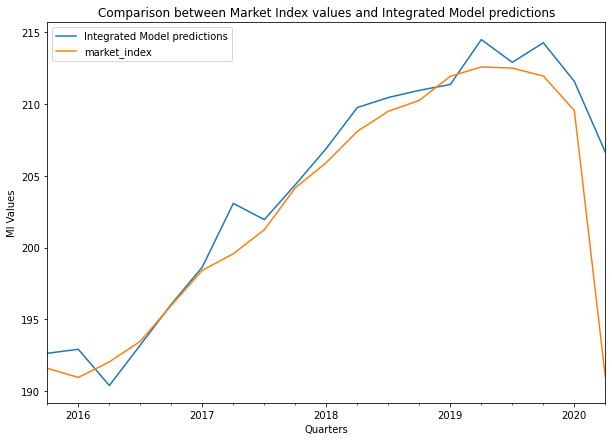

In [ ]:
# Now we construct the integrated model

#First let's plot the 1-step predictions of the integrated model

ra_predictions.name = 'RA predictions'
ts_predictions.columns = ['TS predictions']

int_pred = best_conf * ts_predictions['TS predictions'] + (1-best_conf) * ra_predictions
int_pred.name = 'Integrated Model predictions'

plt.figure(figsize=(10,7))
int_pred.plot(legend=True)
exp_data['market_index']['2015Q4':'2020Q2'].plot(legend=True)
plt.title('Comparison between Market Index values and Integrated Model predictions')
plt.xlabel('Quarters')
plt.ylabel('MI Values')

In [ ]:
#Now we can predict MI values for 2021

#Due to the presence of lagged variables when performing the estimation for each next quarter
#one needs a function that estimates every variable and its lags in every step
def one_step_eval(series, dataset, transf, order, lag):
    #If we are talking about a lagged series we don't need to do one-step
    #predictions. We just use the value from the no lags series and do the
    #prediction on that series
    result = dict()
    dates = get_new_dates(series)
    name = series.name
    if lag == 0:
        proc_series = pre_process(series, transf)
        values = [x for x in proc_series.values]
        model = ARIMA(values, order=order)
        model_fit = model.fit(disp=0)
        values.append(model_fit.forecast()[0][0])
        values = inv_tf(series.values, values, transf)
        result[name] = pd.Series(values, index = dates)
    else:
        feature = name[:-1]
        org_series = dataset[feature]
        proc_series = pre_process(org_series, transf)
        values = [x for x in proc_series.values]
        model = ARIMA(values, order=order)
        model_fit = model.fit(disp=0)
        values.append(model_fit.forecast()[0][0])
        values = inv_tf(series.values, values, transf)
        result[feature] = pd.Series(values, index = dates)
        lag_values = [x for x in series.values]
        lag_values.append(result[feature][-lag-1])
        result[name] = pd.Series(lag_values, index = dates)
    return result

#Now we need a function that receives the full original dataset just with the 
#relevant variables and returns the full dataset with original values + new predictions
def get_pred(original, features, order_list, transf_list, lag_list):
    data = pd.DataFrame()
    for i in range(len(features)):
        var = features[i]
        series = original[var]
        pred_dict = one_step_eval(series, original, transf_list[i], order_list[i], lag_list[i])
        keys = list(pred_dict.keys())
        for elm in keys:
            data[elm] = pred_dict[elm]
    return data
        
# Now we create a function that given the initial parameters and a number of
#iterations N returns the next N predictions for the variables of the RA model
def get_next_n(original, features, order_list, transf_list, lag_list, N):
    current = original
    i=0
    while i<N:
        current = get_pred(current, features, order_list, transf_list, lag_list)
        i = i+1
    return current


#Generation of new dates - in order to get the next estimates for the market index
#it is necessary to have a function that generates the next quarter time object
#to be used as index in the market_index series
def get_new_dates(series):
    times = series.index
    real_time = times[-1]
    real_time = real_time.to_timestamp()
    real_time = real_time + datetime.timedelta(weeks=15)
    real_time = real_time.to_period(freq= 'Q')
    times = times.values
    times = times.tolist()
    times.append(real_time)
    return times

#When using ARIMA to estimate the next value for a given variable sometimes the
#process is applied to a modified version of the variable and thus we need a
#function that given the specific parameters performs the necessary processing
#to the variable so that we can apply the ARIMA model in question
def pre_process(dataset, params):
    if params[0] == 'Log':
        if params[1] == 0:
            values = np.log(dataset)
        else:
            values = np.log(dataset) - np.log(dataset.shift(params[1]))
    else:
        if params[1] == 0:
            values = dataset
        else:
            values = dataset - dataset.shift(params[1])
    values = values.dropna()
    return values

#After performing ARIMA we have the estimations for the processed variable so we
#need a function to perform the inverse transformation done in the pre.processing phase
def inv_tf(original, predicted, transf):
    adj_values = list()
    if transf[0] == 'None':
        if transf[1] == 0:
            adj_values = predicted
        else:
            for k in range(len(predicted)):
                adj_values.append(predicted[-k-1]+original[-k-transf[1]])
            first_lags = original[:transf[1]]
            for j in range(len(first_lags)):
                adj_values.append(first_lags[-j-1])
            adj_values.reverse()
    else:
        if transf[1] == 0:
            adj_values = np.exp(predicted)
        else:
            for k in range(len(predicted)):
                adj_values.append(original[-k-transf[1]]*np.exp(predicted[-k-1]))
            first_lags = original[:transf[1]]
            for j in range(len(first_lags)):
                adj_values.append(first_lags[-j-1])
            adj_values.reverse()
    return adj_values 

#This function receives the explanatory data with the lagged variables, the important features
#the market index series, last existing date and first date to estimate
#It returns a pandas Series with the desired predictions
def get_ra_pred(model_data, features, index, time_limit_inf, time_limit_sup):
    train_data =sm.add_constant(pd.DataFrame(model_data[features][:time_limit_inf]))
    test_data = sm.add_constant(pd.DataFrame(model_data[features][time_limit_sup:]))
    model = sm.OLS(index[:time_limit_inf], train_data).fit()
    predictions = model.predict(test_data)
    predictions.name = 'predictions'
    return predictions


#Parameters for the processing required
#Information about the pre-processing associated with each of the explanatory variables
warnings.filterwarnings('ignore')
order_list = [(0,2,0),(3,0,1),(3,0,0),(1,1,0),(2,1,0),(0,2,0)] 
transf_list = [('None',0),('None',1),('Log',1),('None',0),('None',1),('None',0)]
lag_list = [0,0,3,3,0,0]

#Getting the estimates for 5 quarters ahead for the RA model
ra_feat_pred = get_next_n(exp_data[important_features], selected_features, order_list, transf_list, lag_list, 5)
last_seen = str(exp_data.index[-8])
first_est = str(get_new_dates(exp_data['market_index'])[-8])
ra_pred = get_ra_pred(ra_feat_pred, selected_features, exp_data['market_index'], last_seen, first_est)

#============TS Prediction Function=========================================

#This function takes the already existing market index values, last seen date, first
# date to estimate and the number of futures estimates desired
#It returns a pandas Series with the desired predictions
def get_ts_pred(index, time_limit_inf,time_limit_sup, n, transf):
    train_data = index[:time_limit_inf]
    date_check = train_data        
    dif_index = np.log(train_data) - np.log(train_data.shift(3))
    dif_index = dif_index.dropna()
    current = dif_index
    current_data = [x for x in dif_index.values]
    values_check = [x for x in date_check.values]
    for i in range(n):
        all_dates = get_new_dates(date_check)
        dates = get_new_dates(current)
        model = ARIMA(current_data, order=(4,2,1))
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0][0]
        current_data.append(yhat)
        values_check.append(yhat)
        current = pd.Series(current_data, index = dates)
        date_check = pd.Series(values_check, index = all_dates)
    adj_values = list()
    for k in range(3):
        adj_values.append(train_data[k])
    for l in range(len(current)):
        adj_values.append(adj_values[l]*np.exp(current[l]))
    prediction = pd.Series(adj_values, index = all_dates )
    prediction.name = 'predictions'
    return prediction[time_limit_sup:]

#Getting the next 5 quarter estimates with the TS model
ts_pred = get_ts_pred(exp_data['market_index'], last_seen, first_est, 12, ['Log', 3])

In [ ]:
#This function receives the ts and ra predictions and computes the integrated 
#approach predictions and appends the predictions to the market index series

def add_int_pred(ra_pred, ts_pred, alpha, mi_series, last_time):
    int_pred = alpha * ts_pred + (1-alpha) * ra_pred
    mi_pred = copy.deepcopy(mi_series.loc[:last_time])
    mi_pred = mi_pred.append(int_pred)
    return mi_pred


# Generating the Market Index variable with predictions for 1 year ahead
alpha = 0.545
mi_pred = add_int_pred(ra_pred, ts_pred, alpha, exp_data['market_index'],str(exp_data.index[-8]))

## Auction Data

Now we import the data provided by the company from previous auctions, from 2018 until 2020Q2, that contain information about the clients in each tender, the margins of the proposal (internal and external) and finally if the company won the respective auction

In [ ]:
#Importing the data from previous auctions provided by the company

company_data = pd.read_excel('/content/drive/My Drive/Market_Influence/Data/company_tender_data.xlsx')
company_data = company_data.set_index('Data da proposta')

market_index = mi_pred
market_index.name = 'market_index'

In [ ]:
#Importing the data from previous auctions provided by the company

company_data = pd.read_excel('/content/drive/My Drive/Market_Influence/Data/company_tender_data.xlsx')
company_data['Data da proposta'] = pd.to_datetime(company_data['Data da proposta'])
company_data = company_data.set_index(['Data da proposta'])

# Append market_index to each observation
to_quarters = pd.PeriodIndex(company_data.index, freq='Q')
m_index = list()
for i in range(len(company_data)):
    m_index.append(market_index[to_quarters[i]])
company_data['Market Index'] = m_index
company_data['Win'] = company_data['Win'].astype(int)
company_data['intercept'] = 1
company_data = company_data[['Company',
                    'Overheads', 
                    'Risk', 
                    'Profit',
                    'K',
                    'Market Index',
                    'Win']]
company_list = copy.deepcopy(company_data[['Company','Win']])

### Client Categorization

Before proceedin any further we need to classify the clients according to the following 4 types:

1. Category 0 - Unfriendly: corresponds to those clients with which the company tried to engage in business more than once and the outcome was always negative
2. Category 1 - Friendly: corresponds to those clients with which the company tried to engage in business more than once and the outcome was always positive
3. Category 2 - New: corresponds to those clients from which there isn’t enough information to access the state of their relationship with the company because they only engaged with each other once, independently of the fact that they won or lost the respective auction with said client
4. Category 3 - Regular: corresponds to those clients with which the company tried to engage in business multiple times and the overall outcome is uncertain, i.e. there are some positive and some negative cases


In [ ]:
#Categorize companies by their sympathy

sympathy_categ = dict()
sympathy_categ['new'] = list()
sympathy_categ['regular'] = list()
sympathy_categ['friendly'] = list()
sympathy_categ['unfriendly'] = list()
def seen_before(comp_number):
    what_result = list()
    for i in range(len(company_list)):
        if company_list['Company'][i] == comp_number:
            what_result.append(company_list['Win'][i])
    return what_result

def not_in(comp_number):
    not_in = True
    for categ in sympathy_categ:
        if comp_number in sympathy_categ[categ]:
            not_in = False
            return not_in
    return not_in    

def classify_company(comp_number):
    incidence = seen_before(comp_number)
    if not_in(comp_number):
        check = np.unique(incidence)
        if len(incidence) == 0 or len(incidence) == 1:
            sympathy_categ['new'].append(comp_number)
        elif len(check) == 1:
            if check[0]==0:
                sympathy_categ['unfriendly'].append(comp_number)
            else:
                sympathy_categ['friendly'].append(comp_number)
        elif len(check) == 2:
            sympathy_categ['regular'].append(comp_number)

comp_list = company_list['Company']
for i in range(len(comp_list)):
    classify_company(comp_list[i])

# Categorize sympathy variable

sympathy = copy.deepcopy(company_list['Company'])
def which_cat(value):
    for typ in sympathy_categ:
        for i in sympathy_categ[typ]:
            if i == value:
                return typ
for i in range(len(sympathy)):
    if which_cat(sympathy[i]) == 'new':
        sympathy[i] = 0
    elif which_cat(sympathy[i]) == 'regular':
        sympathy[i] = 1
    elif which_cat(sympathy[i]) == 'friendly':
        sympathy[i] = 2
    else:
        sympathy[i] = 3

# Add variable to dataset
company_data['Sympathy'] = sympathy
# Dummify sympathy variable
symp_dum = pd.get_dummies(sympathy)
symp_list = list()
for i in range(len(symp_dum.columns)):
    symp_list.append('symp_' + str(symp_dum.columns[i]))
symp_dum.columns = symp_list
company_data[symp_list] = symp_dum

### Exploratory Data Analysis

In [ ]:
#Let's just consider the relevant variables and create a new, cleaner dataset

data = copy.deepcopy(company_data)

data = data[['K',
                'Market Index',
                'symp_0', 
                'symp_1', 
                'symp_2',
                'symp_3',
                'Win']]

data.columns = ['K',
                'Market Index',
                'New', 
                'Regular', 
                'Friendly',
                'Unfriendly',
                'Adjudicated']

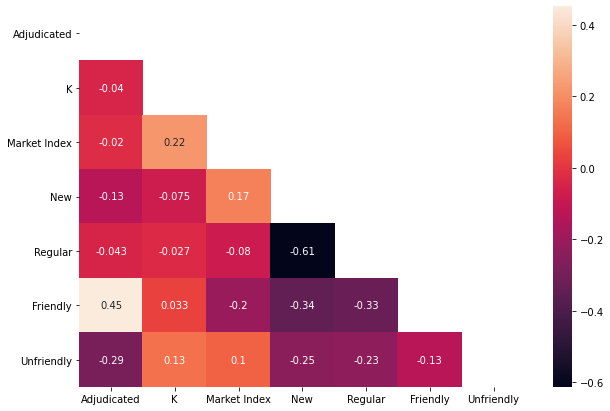

In [ ]:
upp_mat = np.triu(data[['Adjudicated','K','Market Index','New', 'Regular', 'Friendly','Unfriendly']].corr())
plt.figure(figsize=(10,7))
sns.heatmap(data[['Adjudicated','K','Market Index','New', 'Regular', 'Friendly','Unfriendly']].corr(), annot = True, mask = upp_mat)

## Model

For model construction it was important to consider two different approaches. On one hand, a frequentist one with the additional component of robustness considered. On the other hand, a Bayesian approach where prior knowledge of the field and the company can be taken into consideration in the model. In both cases the base model consists of a logistic regression model given by the following expression:

\begin{equation}
    P(Success) = \pi(X) = \frac{exp(\beta_0 + \beta_K X_K + \beta_{MI} X_{MI} + \beta_N X_N + \beta_R X_R + \beta_F X_F + \beta_U X_U)}{1 + exp(\beta_0 + \beta_K X_K + \beta_{MI} X_{MI} + \beta_N X_N + \beta_R X_R + \beta_F X_F + \beta_U X_U)}
\end{equation}

Where the $\beta_i$'s are the coefficients associated with the explanatory variables $X_i$'s which in this case correspond to the global margin variable, K, the market index variable, MI, and the sympathy indicators for each client category, New, N, Regular, R, Friendly, F and Unfriendly, U. The probability of success is then a function of this explanatory variables. The nature of the logistic regression formula constrains the probability to be a value between 0 and 1.

### Frequentist Approach

For the frequentist model we have randomly divided the data in 70\% train data and 30\% test data. As mentioned before the partition is randomly distributed between timespans of the dataset to minimize the impact of the 2020 observations. For each dataset split the best performing model was constructed through a GridSearch approach on the tuning parameters. With the Logistic Regression Python routine  it is possible to adjust various parameters in the model, including the weight associated with the classes of the dependent variable (class_weight), the algorithm used in the optimization problem (solver), the norm used in the penalization (penalty) and the regularization strength (C).

In [ ]:
#Add an intercept column to the data
data['intercept']=1
#Partition data
positions = np.arange(len(data))
random.seed(5)
random.shuffle(positions)
train_s, test_s = data.iloc[positions[:90],:],data.iloc[positions[90:],:]

#Construct logistic model with previously determined best parameters from the GridSearch
logit = LogisticRegression(C=100, 
                           penalty='l2', 
                           solver = 'liblinear',
                           class_weight = {0:1.5, 1:1},
                           fit_intercept = False)

logit_fit = logit.fit(train_s[['K','Market Index','New','Regular','Friendly','Unfriendly']].values,
          train_s['Adjudicated'].values)

In [ ]:
#Lest check the AUC score for this model
y_pred = logit.predict(test_s[['K','Market Index','New','Regular','Friendly','Unfriendly']].values)
roc_auc_score(test_s['Adjudicated'],y_pred)


0.6363636363636364

Now we construct several models for different train/test partitions in order to see if the models' performances remain relatively similar

In [ ]:
# Let's perform 1000 different train/test partitions and compile the results into new dataframe

#Let's store the AUC scores
auc_scores = list()
for i in range(1000):
    #Partition data
    positions = np.arange(len(data))
    random.seed(i)
    random.shuffle(positions)
    train_s, test_s = data.iloc[positions[:90],:],data.iloc[positions[90:],:]

    #Construct logistic model with previously determined best parameters from the GridSearch
    logit = LogisticRegression(C=100, 
                               penalty='l2', 
                               solver = 'liblinear',
                               class_weight = {0:1.5, 1:1},
                               fit_intercept = False)

    logit_fit = logit.fit(train_s[['K','Market Index','New','Regular','Friendly','Unfriendly']].values,
              train_s['Adjudicated'].values)
    y_pred = logit.predict(test_s[['K','Market Index','New','Regular','Friendly','Unfriendly']].values)
    auc_scores.append(roc_auc_score(test_s['Adjudicated'],y_pred))
    

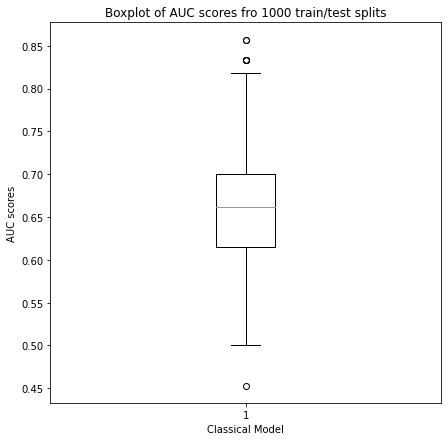

In [ ]:
plt.figure(figsize =(7, 7))
plt.boxplot(auc_scores)
plt.xlabel('Classical Model')
plt.ylabel('AUC scores')
plt.title('Boxplot of AUC scores fro 1000 train/test splits')
plt.show()

There is a lot of variation in the AUC scores, with scores ranging from 45\% to over 85\%. Thus we need to use robust versions of the logistic regression models. In order to robustify the model the technique applied is denominated by the redescending M-estimators method

In [ ]:
#First we need to create some auxiliary functions necessary to obtain the beta coefficients for the robust model

#Logit Function
def F(beta, x):
    return np.exp(np.inner(beta,x))/ (1+np.exp(np.inner(beta,x)))

#Deviance Function
def d(u,y):
    res = np.sqrt(-2*(y * np.log(u) + (1-y)*np.log(1-u)))*np.sign(y-u)
    return res[0]

#Q-Function
def q(u,c):
    return v(u,c)+v(1-u,c)

#V-Function
def v(u,c):
    return 2 * integrate(psi_log, u, 1000,c)

#integrate function
def integrate(f,u,steps,c):
    x = np.linspace(0,u,steps)
    values = list()
    for value in x:
        fx = f(value,c)
        values.append(fx)
    integral = np.sum(values)*u/steps
    return integral

#psi log function
def psi_log(u, c):
    return psi(-2 * np.log(u),c)

# Psi - Function
def ro(u,c):
    if u < c:
        return u
    else:
        return 2* np.sqrt(c*u) - c

#ro Function
def psi(u, c):

    if u < c:
        return 1
    else:
        return np.sqrt(c/u)
    
#Function to minimize
def M(beta):
    x = data[['K','Market Index','New','Regular','Friendly','Unfriendly']].values
    y = data[['Adjudicated']].values
    c=1
    res = 0
    for i in range(len(x)):
        res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
    return res

#Then, to obtain the coefficients we need to minimize the M function using the command optimize.minimize shown below

'''
minimizers = optimize.minimize(M, x0 = [1,-1,0.001,-1,1,1,-1],method = "BFGS")
'''

#We then need to create some function that help us obtain the performance scores with the robust model

# Create Logistic model with the obtained coefficients

def logit_model(x, beta):
    u = np.inner(beta, x)
    prob = np.exp(u)/(1+np.exp(u))
    return prob

def logit_pred(x,y, beta):
    prob = logit_model(x, beta)
    err = (y - prob)*(y-prob)
    return {'error': err , 'prediction': np.round(prob), 'probability': prob}

def logit_rmse(x, y, beta):
    rmse = 0
    for i in range(len(x)):
        rmse = rmse + logit_pred(x[i],y[i], beta)['error']
    rmse = np.sqrt(rmse)
    return rmse

def logit_predictions(x, y, beta):
    predictions = list()
    for i in range(len(x)):
        predictions.append(logit_pred(x[i],y[i], beta)['prediction'])
    return predictions

def logit_prob(x, y, beta):
    predictions = list()
    for i in range(len(x)):
        predictions.append(logit_pred(x[i],y[i], beta)['probability'])
    return predictions

In [ ]:
#Now we obtain the AUC scores for both the classical and robust models in different train/test splits
#We only obtain scores for 20 different splits because the process of obtaining the robust coefficients is quite time consuming



# results = dict()
# results['classical']=list()
# results['robust']=list()
# results['minimizers']=list()

# #Cycle through train/test partitions


# for i in range(20):
#     positions = np.arange(len(data))
#     random.seed(i)
#     random.shuffle(positions)
#     train_s, test_s = data.iloc[positions[:90],:],data.iloc[positions[90:],:]
#     logit = LogisticRegression(C=100, 
#                            penalty='l2', 
#                            solver = 'liblinear',
#                            class_weight = {0:1.5, 1:1},
#                            fit_intercept = True)

#     logit_fit = logit.fit(train_s[['K','Market Index','New','Regular','Friendly','Unfriendly']].values,
#           train_s['Adjudicated'].values)

#     y_pred = logit.predict(test_s[['K','Market Index','New','Regular','Friendly','Unfriendly']].values)
#     auc_classic = roc_auc_score(test_s['Adjudicated'],y_pred)
#     results['classical'].append(auc_classic)
#     print(auc_classic)
#     #Function to minimize
#     def M(beta):
#         x = train_s[['intercept','K','Market Index','New','Regular','Friendly','Unfriendly']].values
#         y = train_s[['Adjudicated']].values
#         c=1
#         res = 0
#         for i in range(len(x)):
#             res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
#         return res
#     minimizers = optimize.minimize(M, x0 = [1,-1,0.001,-1,1,1,-1],method = "BFGS")
#     y_pred2 = logit_predictions(test_s[['intercept','K','Market Index','New','Regular','Friendly','Unfriendly']].values,
#                                 test_s['Adjudicated'].values, minimizers.x)
#     auc_robust = roc_auc_score(test_s['Adjudicated'],y_pred2)
#     results['robust'].append(auc_robust)
#     results['minimizers'].append(minimizers.x)
#     print(auc_robust)
    


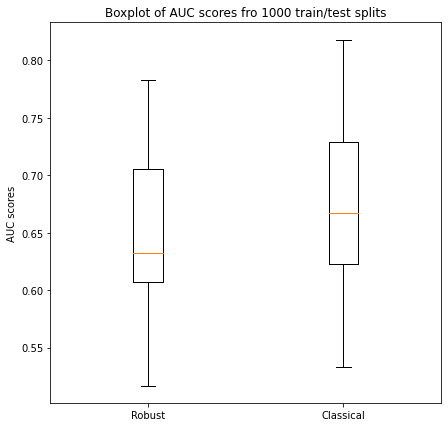

In [ ]:
#Load the results from the classical vs robust comparison

robust_classical_results = pd.read_excel('/content/drive/My Drive/Market_Influence/Data/classical_vs_robust_auc.xlsx')

#Create boxplot to compare models' results

plt.figure(figsize =(7, 7))
plt.boxplot([robust_classical_results['robust'],robust_classical_results['classical'] ], labels = ['Robust', 'Classical'])
plt.ylabel('AUC scores')
plt.title('Boxplot of AUC scores fro 1000 train/test splits')
plt.show()

We see that the robust models have slightly less variance in the results when compared to the classical models while mainting similar values for the 25\%, 50\% and 75\% quantiles.

Then, considering the 20 different robust models computed we calculated the mean value for each coefficient which can be seen in following table. This values can then be used to construct a new logistic regression model that serves illustrative purposes for plotting the probability curves for each client category.


Coefficient & Value

$\beta_0$ = 10.563 

$\beta_K$ = -5.140 

$\beta_{MI}$ = -0.049 

$\beta_N$ = 1.468 

$\beta_R$ = 2.674 

$\beta_F$ = 19.208 

$\beta_U$ = -15.031 

We can then compute the curves for each client category for the success probability as a function of the profit margin for a specific value of MI in Figure \ref{fig:client_curves}. A MI value of 202.309 was selected for illustration purposes, which corresponds to the estimated value for MI in the first quarter of 2021 (with index information only available until the third quarter of 2020).

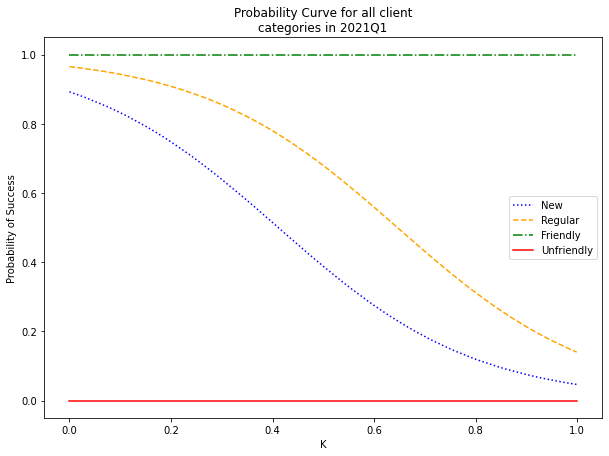

In [ ]:
#Define the robust coefficients

robust_coef = [10.563,-5.140,-0.049,1.468,2.674,19.208,-15.031]

#Before plotting the curves we need to define some auxiliary functions

#Functions necessary for the plot of the curves
lm0 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta3'])))

lm1 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta4'])))

lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta5'])))

lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta6'])))

#Functions that calculate the values for the plot

def logit_model(x, beta):
    u = np.inner(beta, x)
    prob = np.exp(u)/(1+np.exp(u))
    return prob

def logit_pred(x,y, beta):
    prob = logit_model(x, beta)
    err = (y - prob)*(y-prob)
    return {'error': err , 'prediction': np.round(prob), 'probability': prob}

def logit_rmse(x, y, beta):
    rmse = 0
    for i in range(len(x)):
        rmse = rmse + logit_pred(x[i],y[i], beta)['error']
    rmse = np.sqrt(rmse)
    return rmse

def logit_predictions(x, y, beta):
    predictions = list()
    for i in range(len(x)):
        predictions.append(logit_pred(x[i],y[i], beta)['prediction'])
    return predictions

def logit_prob(x, y, beta):
    predictions = list()
    for i in range(len(x)):
        predictions.append(logit_pred(x[i],y[i], beta)['probability'])
    return predictions

def find_symp_pos(categ):
    lista = symp_list
    result = list()
    for i in range(len(lista)):
        if lista[i].split('_')[1] == str(categ):
            result.append(1)
        else:
            result.append(0)
    return result

line_list = ['dotted','dashed','dashdot','solid']
categ_list = ['New','Regular','Friendly','Unfriendly']
color_list = ['blue','orange','green','red']
plt.figure(figsize=(10,7))
for categ in range(4):
    values = list()
    var_levels = np.arange(0,1,0.001)
    for val in var_levels:
        sp_list = find_symp_pos(categ)
        config = np.array([[1,val, 202.389] + sp_list])
        values.append(round(logit_model(config, robust_coef)[0],4))
    plt.plot(var_levels, values, linestyle = line_list[categ], label = categ_list[categ], color = color_list[categ])
plt.title('Probability Curve for all client' + '\n'+
          'categories in 2021Q1')
plt.legend(loc = 'best')
plt.xlabel('K')
plt.ylabel('Probability of Success')
plt.show()

### Bayesian Approach

The other approach for model creation consists on taking advantage of field knowledge and the properties of Bayesian models in order to provide prior information related to the distributions of the coefficients.

For estimation of this model we have used the Python package PyMC3 one can construct Bayesian logistic regression models and define specific prior distributions for the coefficients.

In [ ]:
import arviz as az
import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

In [ ]:
data.head(5)

,K,Market Index,New,Regular,Friendly,Unfriendly,Adjudicated,intercept
Data da proposta,,,,,,,,
2018-02-26,0.342133,205.907363,0,1,0,0,0,1
2018-03-05,0.342133,205.907363,0,1,0,0,0,1
2018-03-05,0.342133,205.907363,1,0,0,0,0,1
2018-03-07,0.342133,205.907363,1,0,0,0,0,1
2018-03-08,0.342133,205.907363,0,0,1,0,1,1


In [ ]:
bayes_data = copy.deepcopy(data)
bayes_data.columns= ['K','Market_Index','New','Regular','Friendly','Unfriendly','Adjudicated','intercept']

positions = np.arange(len(bayes_data))

random.seed(5)
random.shuffle(positions)

train, test = bayes_data.iloc[positions[:90],:],bayes_data.iloc[positions[90:],:]
X_train = train[['K',
                'Market_Index',
                'New', 
                'Regular', 
                'Friendly',
                'Unfriendly']]
X_test = test[['K',
                'Market_Index',
                'New', 
                'Regular', 
                'Friendly',
                'Unfriendly']]
Y_train = train['Adjudicated']
Y_test = test['Adjudicated']

#### Uniform Priors

In [ ]:
labels = X_train.columns
with pm.Model() as logistic_model0:
  #Define priors
  beta0 = pm.Uniform('beta0', 10.563-10, 10.563+10)
  beta1 = pm.Uniform('beta1', -5.140-10, 0)
  beta2 = pm.Uniform('beta2', -0.049-10, -0.049+10)
  beta3 = pm.Uniform("beta3", 1.468-10,1.468+10)
  beta4 = pm.Uniform("beta4", 2.674-10,2.674+10)
  beta5 = pm.Uniform("beta5", 19.208-10,19.208+10)
  beta6 = pm.Uniform("beta6", -15.031-10,-15.031+10)
  
  #Set predictors
  pred = pm.Data("pred", X_train.values)
  K = pred[:,0]
  Market_Index = pred[:,1]
  new = pred[:,2]
  regular = pred[:,3]
  friendly = pred[:,4]
  unfriendly = pred[:,5]

  p = pm.invlogit(beta0 + beta1*K + beta2*Market_Index + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
  
  Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_train)
  #trace0 = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

In [ ]:
#Load model computed with code from previou cell
with logistic_model0:
  trace0 = pm.load_trace('/content/drive/My Drive/Market_Influence/Models/trace0_2')

In [ ]:
#Predict probability values for test data

with logistic_model0:
  #Update values of predictors:
  pm.set_data({"pred": X_test.values})
  posterior_predictive0 = pm.sample_posterior_predictive(trace0, random_seed=5)
  model_pred_unif0 = posterior_predictive0["Adjudicated"]


#Compute AUC score for this particular partition
y_score_unif0 = np.mean(model_pred_unif0, axis=0)
roc_auc_score(y_score=y_score_unif0, y_true=Y_test)

0.5625

#### Mixed Priors

In [ ]:
labels = X_train.columns
with pm.Model() as logistic_model1:
  #Define priors
  beta0 = pm.ChiSquared('beta0', 10.563)
  beta1 = pm.Uniform('beta1', -5.140-10, 0)
  beta2 = pm.StudentT('beta2', nu=5, mu=-0.049, sigma=5)
  beta3 = pm.StudentT("beta3",nu=5, mu=1.468, sigma=5)
  beta4 = pm.StudentT("beta4", nu=5,mu=2.674, sigma=5)
  beta5 = pm.Uniform("beta5", 19.208-10,19.208+10)
  beta6 = pm.Uniform("beta6", -15.031-10,-15.031+10)
  
  #Set predictors
  pred = pm.Data("pred", X_train.values)
  K = pred[:,0]
  Market_Index = pred[:,1]
  new = pred[:,2]
  regular = pred[:,3]
  friendly = pred[:,4]
  unfriendly = pred[:,5]

  p = pm.invlogit(beta0 + beta1*K + beta2*Market_Index + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
  
  Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_train)
  #trace1 = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

In [ ]:
#Load model computed with code from previou cell
with logistic_model1:
  trace1 = pm.load_trace('/content/drive/My Drive/Market_Influence/Models/trace1')

In [ ]:
#Predict probability values for test data

with logistic_model1:
  #Update values of predictors:
  pm.set_data({"pred": X_test.values})
  posterior_predictive1 = pm.sample_posterior_predictive(trace1, random_seed=5)
  model_pred_mixed0 = posterior_predictive1["Adjudicated"]


#Compute AUC score for this particular partition
y_score_mixed0 = np.mean(model_pred_mixed0, axis=0)
roc_auc_score(y_score=y_score_mixed0, y_true=Y_test)

0.5454545454545454

### T-Student Priors

In [ ]:
labels = X_train.columns
with pm.Model() as logistic_model2:
  #Define priors
  beta0 = pm.StudentT('beta0', nu=89, mu=10.563, sigma=10)
  beta1 = pm.StudentT('beta1', nu=89, mu=-5.140, sigma=10)
  beta2 = pm.StudentT('beta2', nu=89, mu=-0.049, sigma=10)
  beta3 = pm.StudentT('beta3', nu=89, mu=1.468, sigma=10)
  beta4 = pm.StudentT('beta4', nu=89, mu=2.674, sigma=10)
  beta5 = pm.StudentT('beta5', nu=89, mu=19.208, sigma=10)
  beta6 = pm.StudentT('beta6', nu=89, mu=-15.031, sigma=10)
  
  #Set predictors
  pred = pm.Data("pred", X_train.values)
  K = pred[:,0]
  Market_Index = pred[:,1]
  new = pred[:,2]
  regular = pred[:,3]
  friendly = pred[:,4]
  unfriendly = pred[:,5]

  p = pm.invlogit(beta0 + beta1*K + beta2*Market_Index + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
  
  Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_train)
  #trace2 = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

In [ ]:
#Load model computed with code from previou cell
with logistic_model2:
  trace2 = pm.load_trace('/content/drive/My Drive/Market_Influence/Models/trace2')

In [ ]:
#Predict probability values for test data

with logistic_model2:
  #Update values of predictors:
  pm.set_data({"pred": X_test.values})
  posterior_predictive2 = pm.sample_posterior_predictive(trace2, random_seed=5)
  model_pred_tstu0 = posterior_predictive2["Adjudicated"]


#Compute AUC score for this particular partition
y_score_tstu0 = np.mean(model_pred_tstu0, axis=0)
roc_auc_score(y_score=y_score_tstu0, y_true=Y_test)

0.4772727272727273

In [ ]:
#Now we plot multiple samples from the posterior predictive dsitribution as well as the mean of those samples
#First we need to define some auxiliary funtions for the plotting phase and to obtain the mean of all the samples

lm0 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta3'])))

lm1 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta4'])))

lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta5'])))

lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta2']*202.389+
                                          samples['beta6'])))

def sample_posterior_lm(samples, trace, lm, size):
  eval = np.linspace(0, 1, size)
  functions = dict()
  i= 0
  for rand_loc in np.random.randint(0, len(trace), samples):
          rand_sample = trace[rand_loc]
          functions[str(i)] = lm(eval, rand_sample)
          i = i+1
  return functions

def mean_function(values, size):
  mean_f = []
  for i in range(len(np.linspace(0, 1, size))):
    temp=0
    for j in range(len(list(values.keys()))):
      temp = temp + values[list(values.keys())[j]][i]
    mean_f.append(temp/len(list(values.keys())))
  return mean_f

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm`

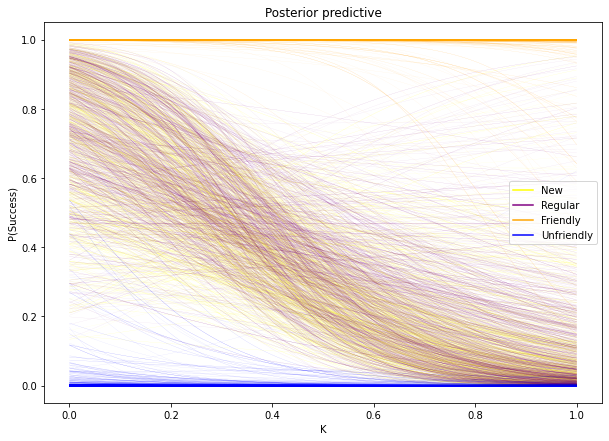

In [ ]:
#Plot of 1000 from the posterior predictive dsitributions for each client category

plt.figure(figsize=(10,7))
pm.plot_posterior_predictive_glm(trace2, eval=np.linspace(0,1,1000), lm=lm0, samples=1000, color="yellow", alpha=0.15)
pm.plot_posterior_predictive_glm(trace2, eval=np.linspace(0,1,1000), lm=lm1, samples=1000, color="purple", alpha=0.15)
pm.plot_posterior_predictive_glm(trace2, eval=np.linspace(0,1,1000), lm=lm2, samples=1000, color="orange", alpha=0.15)
pm.plot_posterior_predictive_glm(trace2, eval=np.linspace(0,1,1000), lm=lm3, samples=1000, color="blue", alpha=0.15)

import matplotlib.lines as mlines

yellow_line = mlines.Line2D(["lm0"], [], color="yellow", label="New")
purple_line = mlines.Line2D(["lm1"], [], color="purple", label="Regular")
orange_line = mlines.Line2D(["lm2"], [], color="orange", label="Friendly")
blue_line = mlines.Line2D(["lm3"], [], color="blue", label="Unfriendly")
plt.legend(handles=[yellow_line, purple_line, orange_line, blue_line], loc="best")
plt.ylabel("P(Success)")
plt.xlabel("K")
plt.show()

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


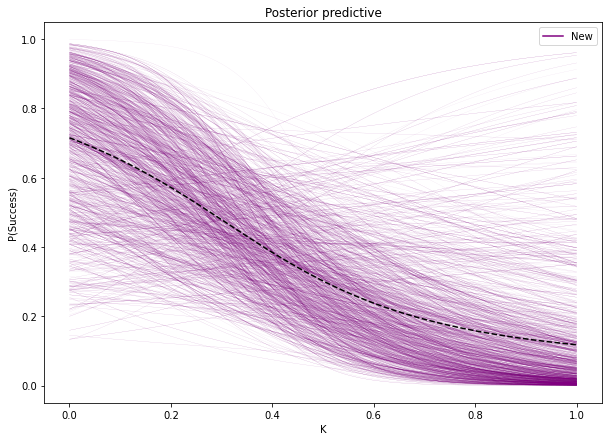

In [ ]:
#We can also take a closer look at the samples for the two most interesting categories: the New and Regular clients
#We can plot n samples from the posterior predictive for those clients and compute the mean curve of those samples

#Here we plot the samples for the New clients

plt.figure(figsize=(10,7))
pm.plot_posterior_predictive_glm(trace2, eval=np.linspace(0,1,500), lm=lm0, samples=2000, color="purple", alpha=0.15)
values_en = sample_posterior_lm(2000, trace2, lm0, 500)
m_en = mean_function(values_en, 500)
purple_line = mlines.Line2D(["lm0"], [], color="purple", label="New")
plt.plot(np.linspace(0,1,500), m_en, linestyle='dashed', color='black', label = 'Mean')
plt.legend(handles=[purple_line], loc="upper right")
plt.ylabel("P(Success)")
plt.xlabel("K")
plt.show()

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


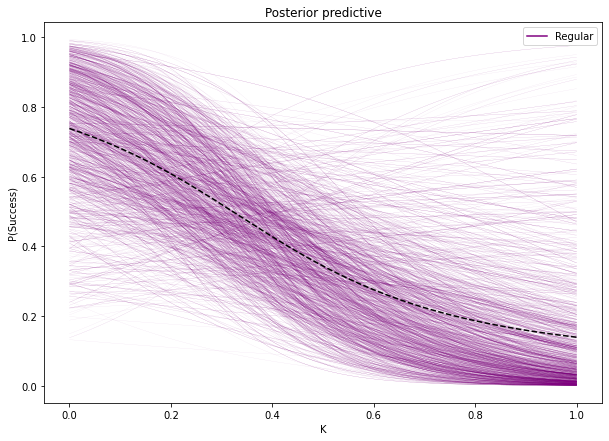

In [ ]:
#Here we plot the samples for the Regular clients

plt.figure(figsize=(10,7))
pm.plot_posterior_predictive_glm(trace2, eval=np.linspace(0,1,500), lm=lm1, samples=2000, color="purple", alpha=0.15)

values_bo = sample_posterior_lm(2000, trace2, lm1, 500)
m_bo = mean_function(values_bo, 500)
purple_line = mlines.Line2D(["lm1"], [], color="purple", label="Regular")
plt.plot(np.linspace(0,1,500), m_bo, linestyle= 'dashed' ,color='black', label = 'Mean')
plt.legend(handles=[purple_line], loc="upper right")
plt.ylabel("P(Success)")
plt.xlabel("K")
plt.show()

Then, after obtaining multiple models with the Bayesian and Frequentist approaches we can compare all of them. Comparing the models graphically can give us in insight into the differences between the two approaches. Note that this comparisons are only of interest for the New and Regular clients because the other two types of clients have very predictable curves.

The curves for the Bayesian models correspond to the mean values from 2000 samples of the posterior predictive.

In [ ]:
# First we need to compute the values for the robust frequentist model with both New and Regular clients

values_freq_new = list()
var_levels = np.arange(0, 1,0.001)
for val in var_levels:
    sp_list = find_symp_pos(0)
    config = np.array([[1, val, 202.389] + sp_list])
    values_freq_new.append(round(logit_model(config, robust_coef)[0],4))

values_freq_reg = list()
var_levels = np.arange(0, 1,0.001)
for val in var_levels:
    sp_list = find_symp_pos(1)
    config = np.array([[1, val, 202.389] + sp_list])
    values_freq_reg.append(round(logit_model(config, robust_coef)[0],4))

#Then we need to get the values from the Uniform priors Bayesian model

values_new_uni = sample_posterior_lm(2000, trace0, lm0, 500)
mean_new_uni = mean_function(values_new_uni, 500)

values_regular_uni = sample_posterior_lm(2000, trace0, lm1, 500)
mean_reg_uni = mean_function(values_regular_uni, 500)


#Then we need to get the values from the Mixed priors Bayesian model

values_new_mixed = sample_posterior_lm(2000, trace1, lm0, 500)
mean_new_mixed = mean_function(values_new_mixed, 500)

values_regular_mixed = sample_posterior_lm(2000, trace1, lm1, 500)
mean_reg_mixed = mean_function(values_regular_mixed, 500)


#Then we need to get the values from the T-Student priors Bayesian model

values_new_tstu = sample_posterior_lm(2000, trace2, lm0, 500)
mean_new_tstu = mean_function(values_new_tstu, 500)

values_regular_tstu = sample_posterior_lm(2000, trace2, lm1, 500)
mean_reg_tstu = mean_function(values_regular_tstu, 500)

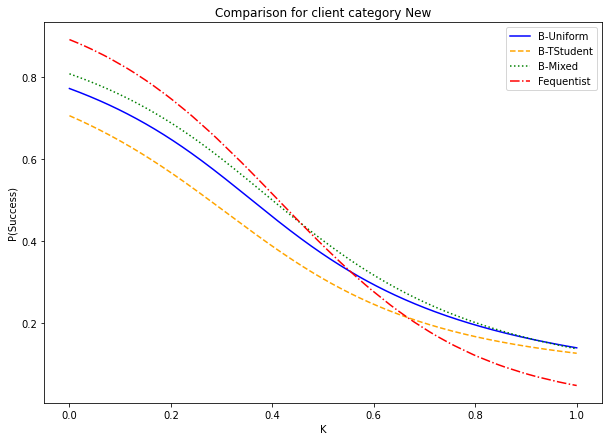

In [ ]:
#Now we can plot all the curves for the New clients

plt.figure(figsize=(10,7))
plt.plot(np.linspace(0,1,500), mean_new_uni, color='blue', label = 'B-Uniform')
plt.plot(np.linspace(0,1,500), mean_new_tstu, linestyle='dashed', color='orange', label = 'B-TStudent')
plt.plot(np.linspace(0,1,500), mean_new_mixed, linestyle='dotted',color='green', label = 'B-Mixed')
plt.plot(np.linspace(0,1,1000), values_freq_new, linestyle='dashdot', color='red', label = 'Fequentist')
plt.legend(loc="upper right")
plt.title('Comparison for client category New')
plt.ylabel("P(Success)")
plt.xlabel("K")
plt.show()

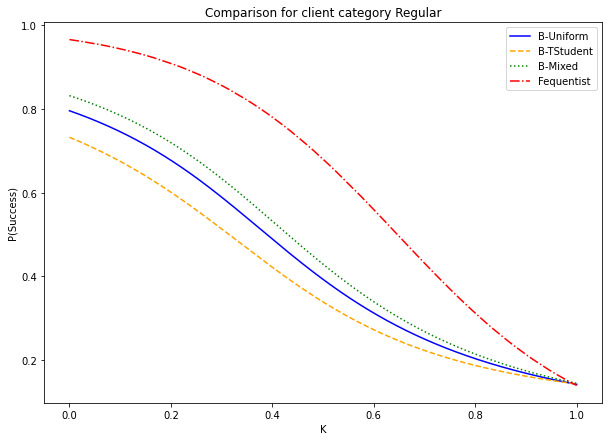

In [ ]:
#Now we can plot all the curves for the Regular clients

plt.figure(figsize=(10,7))
plt.plot(np.linspace(0,1,500), mean_reg_uni, color='blue', label = 'B-Uniform')
plt.plot(np.linspace(0,1,500), mean_reg_tstu, linestyle='dashed' ,color='orange', label = 'B-TStudent')
plt.plot(np.linspace(0,1,500), mean_reg_mixed, linestyle='dotted', color='green', label = 'B-Mixed')
plt.plot(np.linspace(0,1,1000), values_freq_reg, linestyle='dashdot', color='red', label = 'Fequentist')
plt.legend(loc="upper right")
plt.title('Comparison for client category Regular')
plt.ylabel("P(Success)")
plt.xlabel("K")
plt.show()

The Bayesian approach produces more conservative models than the frequentist one.

After discussing this results with the company managers they reafirmed that the Bayesian curves are more in line with what they experience on a daily basis.

## Market Influence

After constructing two different models that estimate the success probability of proposals we can study the market influence on the proposals.

As we have seen in the previous sections, both, the frequentist and the Bayesian models are influenced by the market index variable that is reflected in the corresponding coefficient $\beta_{MI}$.

In this case we use the HMM to model the market states through the observable quarterly MI values from 2006 until 2020Q3.


We used the \textbf{hmmlearn} package in Python with which is possible, given just the observable data, to estimate the HMM parameters, $\lambda = (A, B, \pi)$. For the model it is sufficient to indicate the number of hidden states to be estimated and then, by calling the fit() method the HMM model can be trained. The inferred optimal hidden states can be obtained by calling the predict() method.

We have decided to train the HMM with the new variable, Fluctuation, that corresponds to the percentage change between the MI from last quarter to the current one. We have tested several possibilities for the number of states: twp, three and four. The four and three states models ended up with artificial data separations without the clear economic meaning.

In [ ]:
pip install hmmlearn

In [ ]:
import hmmlearn
# Create new variable Flucutation that corresponds to the percentage change in the MI from the previous quarter to the current one 

fluctuation = list()
for i in np.arange(1,len(market_index)):
  exact = np.round((market_index.values[i]-market_index.values[i-1])/market_index.values[i-1]*100,3)
  fluctuation.append(exact)
fluctuation.append(0)

In [ ]:
#Train HMM and obtain the Hidden States

from hmmlearn.hmm import GaussianHMM

num_components = 2
hidden_model = GaussianHMM(n_components = num_components, covariance_type='full' , random_state=4)
x = np.column_stack([fluctuation])
hidden_model.fit(x)

hidden_states = hidden_model.predict(x)

for i in range(hidden_model.n_components):
  print('\nHidden state', i)
  print('Mean =', round(hidden_model.means_[i][0],3))
  print('Variance =', round(np.diag(hidden_model.covars_[i])[0], 3))


Hidden state 0
Mean = -0.189
Variance = 7.81

Hidden state 1
Mean = 0.68
Variance = 0.353


We can define state 0 as being the Turbulent State while state 1 is the Stable State.

In [ ]:
#Transition Matrix
np.round(hidden_model.transmat_,3)

array([[0.871, 0.129],
       [0.049, 0.951]])

In [ ]:
#Initial Probabilities

np.round(hidden_model.startprob_,10)

array([0., 1.])

In [ ]:
# Create panda series with the fluctuation values

flu = pd.Series(fluctuation, market_index.index)

# Append fluctuation and hidden state to each observation, i.e. add to the data the Fluctuation and Hidden States variables
flu = pd.Series(fluctuation, market_index.index)
hid = pd.Series(hidden_states, market_index.index)
to_quartes = pd.PeriodIndex(data.index, freq='Q')
fluct = list()
hidden = list()
for i in range(len(data)):
    fluct.append(flu[to_quartes[i]])
    hidden.append(hid[to_quartes[i]])
data['Fluctuation'] = fluct
data['Hidden States'] = hidden

In [ ]:
# Dummify hidden states variable
hide = data['Hidden States']
hid_dum = pd.get_dummies(hide)
hid_list = list()
for i in range(len(hid_dum.columns)):
    hid_list.append('hid_' + str(hid_dum.columns[i]))
hid_dum.columns = hid_list
data[hid_list] = hid_dum

In [ ]:
data.head(5)

,K,Market Index,New,Regular,Friendly,Unfriendly,Adjudicated,intercept,Fluctuation,Hidden States,hid_0,hid_1
Data da proposta,,,,,,,,,,,,
2018-02-26,0.342133,205.907363,0,1,0,0,0,1,1.055,1,0,1
2018-03-05,0.342133,205.907363,0,1,0,0,0,1,1.055,1,0,1
2018-03-05,0.342133,205.907363,1,0,0,0,0,1,1.055,1,0,1
2018-03-07,0.342133,205.907363,1,0,0,0,0,1,1.055,1,0,1
2018-03-08,0.342133,205.907363,0,0,1,0,1,1,1.055,1,0,1


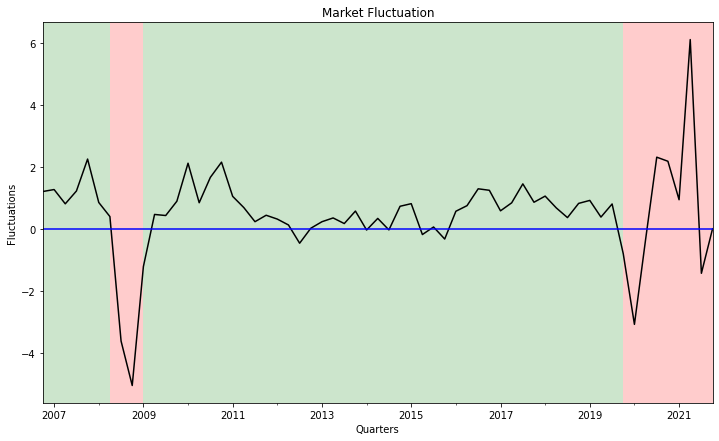

In [ ]:
# We can plot the evolution of the fluctuation and the predicted hidden states to analyse if the predictions adjust well to the data

plt.figure(figsize=(12,7))
flu.plot(color='black', title='Market Fluctuation', xlabel = 'Quarters', ylabel='Fluctuations')
plt.axhline(y=0, color='blue')
plt.axvspan(hid.index[0],hid.index[6], facecolor='green', alpha=0.2)
plt.axvspan(hid.index[6],hid.index[9], facecolor='red', alpha=0.2)
plt.axvspan(hid.index[9],hid.index[-9], facecolor='green', alpha=0.2)
plt.axvspan(hid.index[-9],hid.index[-1], facecolor='red', alpha=0.2)

#### Market State Models

We designate by Market States models the group of logistic regression models, with both frequentist and Bayesian approaches, where the market index is removed and it is added the influence of the Stable/Turbulent market states. The goal is to obtain better performances with this new models which would mean that the market influence would have been captured by the market states constructed through HMM.

In [ ]:
# We now compute and compare the Bayesian and frequentist models using the market states instead of the MI variable

#Partition Dataset
data_state_0 = copy.deepcopy(data[data["hid_0"]==1])
data_state_1 = copy.deepcopy(data[data["hid_1"]==1])

#Bayesian Model for partition 0 == Turbulent Market

positions = np.arange(len(data_state_0))
random.seed(5)
random.shuffle(positions)
train_s0, test_s0 = data_state_0.iloc[positions[:25],:],data_state_0.iloc[positions[25:],:]
X_trains0 = train_s0[['K','Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
X_tests0 = test_s0[['K','Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
Y_trains0 = train_s0['Adjudicated']
Y_tests0 = test_s0['Adjudicated']
#Compute Bayesian model with generalized T-Student priors

labels = X_trains0.columns
with pm.Model() as logistic_models0:
  #Define priors
  beta0 = pm.StudentT('beta0', nu=15, mu=10.563, sigma=10)
  beta1 = pm.StudentT('beta1', nu=15, mu=-5.140, sigma=10)
  beta3 = pm.StudentT('beta3', nu=15, mu=1.468, sigma=10)
  beta4 = pm.StudentT('beta4', nu=15, mu=2.674, sigma=10)
  beta5 = pm.StudentT('beta5', nu=15, mu=19.208, sigma=10)
  beta6 = pm.StudentT('beta6', nu=15, mu=-15.031, sigma=10)
  
  #Set predictors
  pred = pm.Data("pred", X_trains0.values)
  K = pred[:,0]
  symp_0 = pred[:,2]
  symp_1 = pred[:,3]
  symp_2 = pred[:,4]
  symp_3 = pred[:,5]

  p = pm.Deterministic("p", pm.math.invlogit(beta0 + beta1*K + beta3*symp_0 + beta4*symp_1 + beta5*symp_2 + beta6*symp_3 ))
  
  Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains0)
  #traces0 = pm.sample(3000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)




In [ ]:
#Load model from previous cell
with logistic_models0:
  traces0 = pm.load_trace('/content/drive/My Drive/Market_Influence/Models/traces0')

'/content/drive/My Drive/Market_Influence/Models/traces0'

In [ ]:
#Bayesian Model for partition 1 == Stable Market


positions = np.arange(len(data_state_1))
random.seed(5)
random.shuffle(positions)
train_s1, test_s1 = data_state_1.iloc[positions[:60],:],data_state_1.iloc[positions[60:],:]
X_trains1 = train_s1[['K','Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
X_tests1 = test_s1[['K','Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
Y_trains1 = train_s1['Adjudicated']
Y_tests1 = test_s1['Adjudicated']
#Compute Bayesian model with generalized T-Student priors

labels = X_trains1.columns
with pm.Model() as logistic_models1:
  #Define priors
  beta0 = pm.StudentT('beta0', nu=15, mu=10.563, sigma=10)
  beta1 = pm.StudentT('beta1', nu=15, mu=-5.140, sigma=10)
  beta3 = pm.StudentT('beta3', nu=15, mu=1.468, sigma=10)
  beta4 = pm.StudentT('beta4', nu=15, mu=2.674, sigma=10)
  beta5 = pm.StudentT('beta5', nu=15, mu=19.208, sigma=10)
  beta6 = pm.StudentT('beta6', nu=15, mu=-15.031, sigma=10)
  
  #Set predictors
  pred = pm.Data("pred", X_trains1.values)
  K = pred[:,0]
  symp_0 = pred[:,2]
  symp_1 = pred[:,3]
  symp_2 = pred[:,4]
  symp_3 = pred[:,5]

  p = pm.Deterministic("p", pm.math.invlogit(beta0 + beta1*K + beta3*symp_0 + beta4*symp_1 + beta5*symp_2 + beta6*symp_3 ))
  
  Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains1)
  #traces1 = pm.sample(3000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)


#Load model computed with code from previously
#with logistic_models1:
#  traces1 = pm.load_trace('/content/drive/My Drive/Market_Influence/Models/trace1_2')

In [ ]:
#Load model from previous cell
with logistic_models1:
  traces1 = pm.load_trace('/content/drive/My Drive/Market_Influence/Models/traces1')

In [ ]:
#Now we calculate the coefficients for the frequentist models

#But first we need to redefined some auxiliar functions for the robust estimation

#Logit Function
def F(beta, x):
    return np.exp(np.inner(beta,x))/ (1+np.exp(np.inner(beta,x)))

#Deviance Function
def d(u,y):
    res = np.sqrt(-2*(y * np.log(u) + (1-y)*np.log(1-u)))*np.sign(y-u)
    return res

#Q-Function
def q(u,c):
    return v(u,c)+v(1-u,c)

#V-Function
def v(u,c):
    return 2 * integrate(psi_log, u, 1000,c)

#integrate function
def integrate(f,u,steps,c):
    x = np.linspace(0,u,steps)
    values = list()
    for value in x:
        fx = f(value,c)
        values.append(fx)
    integral = np.sum(values)*u/steps
    return integral

#psi log function
def psi_log(u, c):
    return psi(-2 * np.log(u),c)

# Psi - Function
def ro(u,c):
    if u < c:
        return u
    else:
        return 2* np.sqrt(c*u) - c

#ro Function
def psi(u, c):

    if u < c:
        return 1
    else:
        return np.sqrt(c/u)

In [ ]:
#Frequentist Robust Model for partition 0 == Turbulent Market

#Function to minimize
def M0(beta):
    x = X_trains0[['intercept','K','New','Regular','Friendly','Unfriendly']].values
    y = Y_trains0.values
    c=1
    res = 0
    for i in range(len(x)):
        res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
    return res

minimizers0 = optimize.minimize(M0, x0 = [1,-1, -1,1,1,-1],method = "BFGS")


In [ ]:
minimizers0.x

array([  0.98369076,  -1.28520719,  -1.1963794 ,  -0.3960377 ,
        17.19122604, -15.61520807])

In [ ]:
#Coefficients for the robust model in Turbulent State

betas0 = [  0.98369076,  -1.28520719,  -1.1963794 ,  -0.3960377 , 17.19122604, -15.61520807]

In [ ]:
#Frequentist Robust Model for partition 1 == Stable Market

#Function to minimize
def M1(beta):
    x = X_trains1[['intercept','K','New','Regular','Friendly','Unfriendly']].values
    y = Y_trains1.values
    c=1
    res = 0
    for i in range(len(x)):
        res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
    return res

minimizers1 = optimize.minimize(M1, x0 = [1,-1, -1,1,1,-1],method = "BFGS")

In [ ]:
#Coefficients for the robust model in Turbulent State

betas1 = [  2.05506269,  -4.99508859,  -0.20729284,  -0.7351593 , 16.88614042, -14.89052575]

In [ ]:
#Now we can compute the curves for both the frequentist and bayesian models

#Frequentist model for New Clients in Turbulent State
values_freq_new_t = list()
var_levels = np.arange(0, 1,0.001)
for val in var_levels:
    sp_list = find_symp_pos(0)
    config = np.array([[1, val] + sp_list])
    values_freq_new_t.append(round(logit_model(config[0], betas0),4))


#Frequentist model for Regular Clients in Turbulent State
values_freq_reg_t = list()
var_levels = np.arange(0, 1,0.001)
for val in var_levels:
    sp_list = find_symp_pos(1)
    config = np.array([[1, val] + sp_list])
    values_freq_reg_t.append(round(logit_model(config[0], betas0),4))

#Frequentist model for New Clients in Stable State
values_freq_new_s = list()
var_levels = np.arange(0, 1,0.001)
for val in var_levels:
    sp_list = find_symp_pos(0)
    config = np.array([[1, val] + sp_list])
    values_freq_new_s.append(round(logit_model(config[0], betas1),4))

#Frequentist model for Regular Clients in Stable State
values_freq_reg_s = list()
var_levels = np.arange(0, 1,0.001)
for val in var_levels:
    sp_list = find_symp_pos(1)
    config = np.array([[1, val] + sp_list])
    values_freq_reg_s.append(round(logit_model(config[0], betas1),4))

#We need to define auxiliar functions necessary to sample from the posterior predictive for specific clients

lms_new = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta3'])))

lms_reg = lambda x, samples: 1 / (1 + np.exp(-(samples['beta0'] +
                                          samples['beta1']*x +
                                          samples['beta4'])))

#Bayesian model for New Clients in Turbulent State
sample_new_t2 = sample_posterior_lm(2000, traces0, lms_new, 500)
mean_new_t2 = mean_function(sample_new_t2, 500)


#Bayesian model for New Clients in Stable State
sample_new_s2 = sample_posterior_lm(2000, traces1, lms_new, 500)
mean_new_s2 = mean_function(sample_new_s2, 500)


#Bayesian model for Regular Clients in Turbulent State
sample_reg_t2 = sample_posterior_lm(2000, traces0, lms_reg, 500)
mean_reg_t2 = mean_function(sample_reg_t2, 500)


#Bayesian model for Regular Clients in Stable State
sample_reg_s2 = sample_posterior_lm(2000, traces1, lms_reg, 500)
mean_reg_s2 = mean_function(sample_reg_s2, 500)



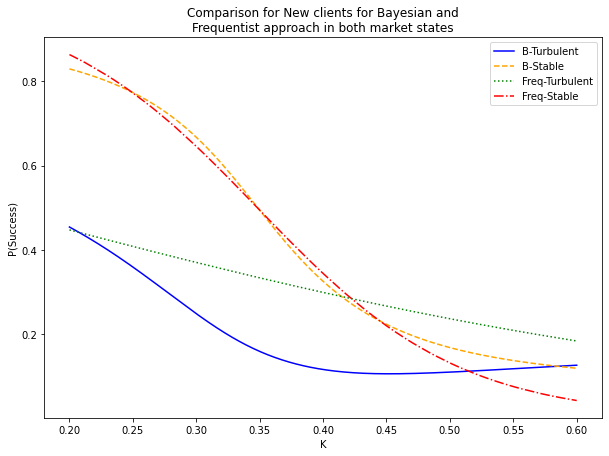

In [ ]:
#Plot for comparison of Bayesian and Frequentist models in New clients

plt.figure(figsize=(10,7))
plt.plot(np.linspace(0.2,0.6,500), mean_new_t2, linestyle='solid', color='blue', label = 'B-Turbulent')
plt.plot(np.linspace(0.2,0.6,500), mean_new_s2,linestyle='dashed', color='orange', label = 'B-Stable')
plt.plot(np.linspace(0.2,0.6,1000), values_freq_new_t, linestyle='dotted',color='green', label = 'Freq-Turbulent')
plt.plot(np.linspace(0.2,0.6,1000), values_freq_new_s, linestyle='dashdot',color='red', label = 'Freq-Stable')
plt.legend(loc="upper right")
plt.title('Comparison for New clients for Bayesian and' +'\n' + 'Frequentist approach in both market states')
plt.ylabel("P(Success)")
plt.xlabel("K")
plt.show()

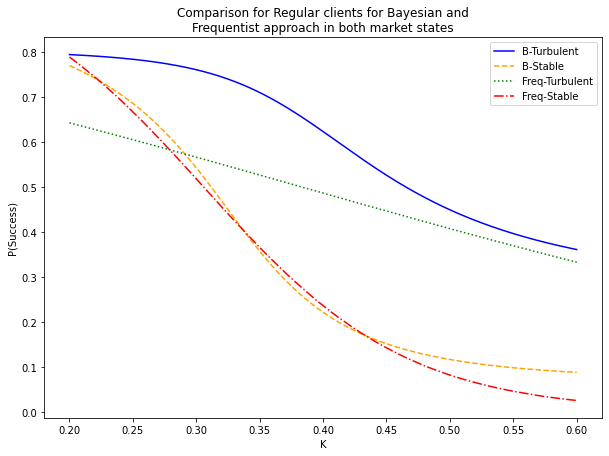

In [ ]:
#Plot for comparison of Bayesian and Frequentist models in Regular clients

plt.figure(figsize=(10,7))
plt.plot(np.linspace(0.2,0.6,500), mean_reg_t2, linestyle='solid', color='blue', label = 'B-Turbulent')
plt.plot(np.linspace(0.2,0.6,500), mean_reg_s2,linestyle='dashed', color='orange', label = 'B-Stable')
plt.plot(np.linspace(0.2,0.6,1000), values_freq_reg_t, linestyle='dotted',color='green', label = 'Freq-Turbulent')
plt.plot(np.linspace(0.2,0.6,1000), values_freq_reg_s, linestyle='dashdot',color='red', label = 'Freq-Stable')
plt.legend(loc="upper right")
plt.title('Comparison for Regular clients for Bayesian and' +'\n' + 'Frequentist approach in both market states')
plt.ylabel("P(Success)")
plt.xlabel("K")
plt.show()

The clients in the Regular category have the Stable/Turbulent Market relationship inverted, i.e. for both the frequentist model and the Bayesian model, the company is expected to perform better in Bear Market Situations than in Bull Market situations with clients with a previous relationship than didn't overly favour or disfavour the company. At first glance this results seems counter intuitive and quite odd so some further analysis of this situation was required. 

In [ ]:
datas_new = copy.deepcopy(data_state_1[data_state_1["New"]==1])
datas_reg = copy.deepcopy(data_state_1[data_state_1["Regular"]==1])
datat_new = copy.deepcopy(data_state_0[data_state_0["New"]==1])
datat_reg = copy.deepcopy(data_state_0[data_state_0["Regular"]==1])

datas_new_lose = copy.deepcopy(datas_new[datas_new["Adjudicated"]==0])
datas_new_win = copy.deepcopy(datas_new[datas_new["Adjudicated"]==1])
datas_reg_lose = copy.deepcopy(datas_reg[datas_reg["Adjudicated"]==0])
datas_reg_win = copy.deepcopy(datas_reg[datas_reg["Adjudicated"]==1])

datat_new_lose = copy.deepcopy(datat_new[datat_new["Adjudicated"]==0])
datat_new_win = copy.deepcopy(datat_new[datat_new["Adjudicated"]==1])
datat_reg_lose = copy.deepcopy(datat_reg[datat_reg["Adjudicated"]==0])
datat_reg_win = copy.deepcopy(datat_reg[datat_reg["Adjudicated"]==1])

Text(0.5, 1.0, 'Cases for New clients in Turbulent and Stable Markets')

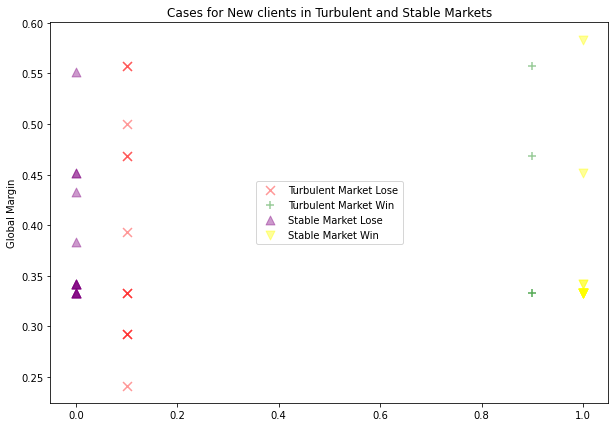

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(np.repeat(0.1,len(datat_new_lose['K'].values)),datat_new_lose['K'].values, color='red', marker='x', s=80,alpha=0.4)
plt.scatter(np.repeat(0.9,len(datat_new_win['K'].values)),datat_new_win['K'].values,color='green', marker='+', s=80,alpha=0.4)
plt.scatter(np.repeat(0,len(datas_new_lose['K'].values)),datas_new_lose['K'].values, color='purple', marker='^', s=80,alpha=0.4)
plt.scatter(np.repeat(1,len(datas_new_win['K'].values)),datas_new_win['K'].values,color='yellow', marker='v', s=80,alpha=0.4)
plt.legend(['Turbulent Market Lose','Turbulent Market Win','Stable Market Lose','Stable Market Win'], loc="center")
plt.ylabel('Global Margin')
plt.title('Cases for New clients in Turbulent and Stable Markets')

Text(0.5, 1.0, 'Cases for Regular clients in Turbulent and Stable Markets')

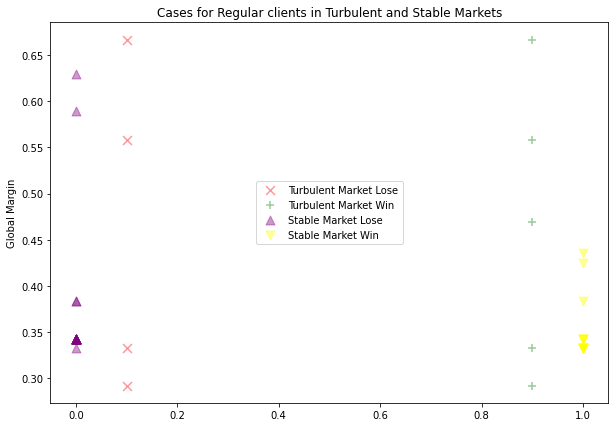

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(np.repeat(0.1,len(datat_reg_lose['K'].values)),datat_reg_lose['K'].values, color='red', marker='x', s=80,alpha=0.4)
plt.scatter(np.repeat(0.9,len(datat_reg_win['K'].values)),datat_reg_win['K'].values,color='green', marker='+', s=80,alpha=0.4)
plt.scatter(np.repeat(0,len(datas_reg_lose['K'].values)),datas_reg_lose['K'].values, color='purple', marker='^', s=80,alpha=0.4)
plt.scatter(np.repeat(1,len(datas_reg_win['K'].values)),datas_reg_win['K'].values,color='yellow', marker='v', s=80,alpha=0.4)
plt.legend(['Turbulent Market Lose','Turbulent Market Win','Stable Market Lose','Stable Market Win'], loc="center")
plt.ylabel('Global Margin')
plt.title('Cases for Regular clients in Turbulent and Stable Markets')

Looking at each individual observation and its respective estimated probability using the Bayesian model the New clients have, for both Stable and Turbulent markets observations with high and low profit margins in the Win and Lose categories whereas, for clients in the Both category the Stable Market observations are much more concentrated in the lower side of the profit margin spectrum with the Turbulent Market observations having more cases of high profit margins both in the Win and Lose categories. This translates into a more optimistic curve in Turbulent Market compared to Stable Market for the clients in the Regular category.

## Final Results

After having computed all the models and, in order to deduce if the division of the data into the two market states is advantageous to better understandin and predicting the performance of future tenders we cycle trhough several train/test partitions of the data, construct all the different types of models already described and then calculate the AUC scores for the test partition. The results from all the iterations can then be compared using boxplots to analyse the overall performance of all the models.

In [ ]:
#In each iteration we first partition the dataset and then compute the models and respective AUC score which are the following:
#Simple Frequentist model with MI variable
#Frequentist model with fluctuation variable
#Frequentist model with the market states

#Bayesian model with Uniform Priors and MI variable
#Bayesian model with Mixed Priors and MI variable
#Bayesian model with generalized T-Student Priors and MI variable
#Bayesian model with Uniform Priors and Fluctuation variable
#Bayesian model with Mixed Priors and Fluctuation variable
#Bayesian model with generalized T-Student Priors and Fluctuation variable
#Bayesian model with the market states (generalized T-Student priors)

#Variable where the AUC score will be stored
# final_results = dict()
# final_results['Freq']=list()
# final_results['Freq F']=list()
# final_results['Freq States']=list()
# final_results['B-Unif']=list()
# final_results['B F-Unif']=list()
# final_results['B-Mixed']=list()
# final_results['B F-Mixed']=list()
# final_results['B-Tstu']=list()
# final_results['B F-Tstu']=list()
# final_results['B States']=list()


# for seed in range(20):
#   #Partition the datasets into train/test for both market states dataframes
#   positions = np.arange(len(data_state_0))
#   random.seed(seed)
#   random.shuffle(positions)
#   train_s0, test_s0 = data_state_0.iloc[positions[:25],:],data_state_0.iloc[positions[25:],:]
#   X_trains0 = train_s0[['K','Market Index','Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
#   X_tests0 = test_s0[['K','Market Index','Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
#   Y_trains0 = train_s0['Adjudicated']
#   Y_tests0 = test_s0['Adjudicated']

#   positions = np.arange(len(data_state_1))
#   random.seed(seed)
#   random.shuffle(positions)
#   train_s1, test_s1 = data_state_1.iloc[positions[:60],:],data_state_1.iloc[positions[60:],:]
#   X_trains1 = train_s1[['K','Market Index', 'Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
#   X_tests1 = test_s1[['K','Market Index','Fluctuation','New','Regular','Friendly','Unfriendly','intercept']]
#   Y_trains1 = train_s1['Adjudicated']
#   Y_tests1 = test_s1['Adjudicated']

#   #Merge the train partitions and the test partitions to use in the models that don't have the market states
#   X_full = [X_trains0, X_trains1]
#   Y_full = [Y_trains0, Y_trains1]
#   X_trains = pd.concat(X_full)
#   Y_trains = pd.concat(Y_full)
#   X_full2 = [X_tests0, X_tests1]
#   Y_full2 = [Y_tests0, Y_tests1]
#   X_tests = pd.concat(X_full2)
#   Y_tests = pd.concat(Y_full2)

#   #Simple Frequentist model with MI variable____________________________________
#   def M0(beta):
#     x = X_trains[['intercept', 'K','Market Index','New','Regular','Friendly','Unfriendly']].values
#     y = Y_trains.values
#     c=1
#     res = 0
#     for i in range(len(x)):
#         res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
#     return res
  
#   #Calculate beta coefficients
#   minimizers0 = optimize.minimize(M0, x0 = [1,-1,0.1,-1,1,1,-1],method = "BFGS")
#   beta0 = minimizers0.x

#   #Get the predictions and the AUC score
#   y_scores_fm = list()
#   for i in range(len(X_tests)):
#     config = [1] + list(X_tests[[ 'K','Market Index', 'New','Regular','Friendly','Unfriendly']].iloc[i,:].values)
#     result = logit_pred(config, 1, beta0)
#     y_scores_fm.append(result['prediction'])

#   auc_score_fm =np.round(roc_auc_score(y_score=y_scores_fm, y_true=Y_tests),3)
#   final_results['Freq'].append(auc_score_fm)


#   #Frequentist model with fluctuation variable__________________________________
#   def M1(beta):
#     x = X_trains[['intercept', 'K','Fluctuation','New','Regular','Friendly','Unfriendly']].values
#     y = Y_trains.values
#     c=1
#     res = 0
#     for i in range(len(x)):
#         res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
#     return res
  
#   #Calculate beta coefficients
#   minimizers1 = optimize.minimize(M1, x0 = [1,-1,0.1,-1,1,1,-1],method = "BFGS")
#   beta1 = minimizers1.x

#   #Get the predictions and the AUC score
#   y_scores_ff = list()
#   for i in range(len(X_tests)):
#     config = [1] + list(X_tests[[ 'K','Fluctuation', 'New','Regular','Friendly','Unfriendly']].iloc[i,:].values)
#     result = logit_pred(config, 1, beta1)
#     y_scores_ff.append(result['prediction'])

#   auc_score_ff =np.round(roc_auc_score(y_score=y_scores_ff, y_true=Y_tests),3)
#   final_results['Freq F'].append(auc_score_ff)

#   #Frequentist model with the market states_____________________________________
#   def M2(beta):
#     x = X_trains0[['intercept', 'K','New','Regular','Friendly','Unfriendly']].values
#     y = Y_trains0.values
#     c=1
#     res = 0
#     for i in range(len(x)):
#         res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
#     return res
  
#   def M3(beta):
#     x = X_trains1[['intercept', 'K','New','Regular','Friendly','Unfriendly']].values
#     y = Y_trains1.values
#     c=1
#     res = 0
#     for i in range(len(x)):
#         res=res+ (ro(d(F(beta,x[i]),y[i])*d(F(beta,x[i]),y[i]),c)+q(F(beta,x[i]),c))
#     return res

#   #Calculate beta coefficients
#   minimizers2 = optimize.minimize(M2, x0 = [1,-1,-1,1,1,-1],method = "BFGS")
#   beta2 = minimizers2.x

#   minimizers3 = optimize.minimize(M3, x0 = [1,-1,-1,1,1,-1],method = "BFGS")
#   beta3 = minimizers3.x

#   #Get the predictions and the AUC score
#   y_scores_s = list()
#   for i in range(len(X_tests0)):
#     config = [1] + list(X_tests0[[ 'K', 'New','Regular','Friendly','Unfriendly']].iloc[i,:].values)
#     result = logit_pred(config, 1, beta2)
#     y_scores_s.append(result['prediction'])

#   for i in range(len(X_tests1)):
#     config = [1] + list(X_tests1[[ 'K', 'New','Regular','Friendly','Unfriendly']].iloc[i,:].values)
#     result = logit_pred(config, 1, beta3)
#     y_scores_s.append(result['prediction'])

#   auc_score_s =np.round(roc_auc_score(y_score=y_scores_s, y_true=Y_tests),3)
#   final_results['Freq States'].append(auc_score_s)


#   # Bayesian model with Uniform Priors and MI variable__________________________

#   #Construct the model
#   with pm.Model() as logistic_model_unif:
#     #Define priors
#     beta0 = pm.Uniform('beta0', 10.563-10, 10.563+10)
#     beta1 = pm.Uniform('beta1', -5.140-10, 0)
#     beta2 = pm.Uniform('beta2', -0.049-10, -0.049+10)
#     beta3 = pm.Uniform("beta3", 1.468-10,1.468+10)
#     beta4 = pm.Uniform("beta4", 2.674-10,2.674+10)
#     beta5 = pm.Uniform("beta5", 19.208-10,19.208+10)
#     beta6 = pm.Uniform("beta6", -15.031-10,-15.031+10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains.values)
#     K = pred[:,0]
#     Market_Index = pred[:,1]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta2*Market_Index + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains)
#     trace_unif = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   #Get the predictions
#   with logistic_model_unif:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests.values})
#     posterior_predictive_unif = pm.sample_posterior_predictive(trace_unif, random_seed=5)
#     model_preds_unif = posterior_predictive_unif["Adjudicated"]
  
#   #Get AUC score
#   y_scores_unif = np.mean(model_preds_unif, axis=0)
#   auc_score_unif = roc_auc_score(y_score=y_scores_unif, y_true=Y_tests)
#   final_results['B-Unif'].append(auc_score_unif)

#   # Bayesian model with Uniform Priors and Fluctuation variable_________________

#   #Construct the model
#   with pm.Model() as logistic_model_unif_f:
#     #Define priors
#     beta0 = pm.Uniform('beta0', 10.563-10, 10.563+10)
#     beta1 = pm.Uniform('beta1', -5.140-10, 0)
#     beta2 = pm.Uniform('beta2', -10, 10)
#     beta3 = pm.Uniform("beta3", 1.468-10,1.468+10)
#     beta4 = pm.Uniform("beta4", 2.674-10,2.674+10)
#     beta5 = pm.Uniform("beta5", 19.208-10,19.208+10)
#     beta6 = pm.Uniform("beta6", -15.031-10,-15.031+10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains.values)
#     K = pred[:,0]
#     Fluctuation = pred[:,2]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta2*Fluctuation + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains)
#     trace_unif_f = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   #Get the predictions
#   with logistic_model_unif_f:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests.values})
#     posterior_predictive_unif_f = pm.sample_posterior_predictive(trace_unif_f, random_seed=5)
#     model_preds_unif_f = posterior_predictive_unif_f["Adjudicated"]
  
#   #Get AUC score
#   y_scores_unif_f = np.mean(model_preds_unif_f, axis=0)
#   auc_score_unif_f = roc_auc_score(y_score=y_scores_unif_f, y_true=Y_tests)
#   final_results['B F-Unif'].append(auc_score_unif_f)


#   # Bayesian model with Mixed Priors and MI variable__________________________

#   #Construct the model
#   with pm.Model() as logistic_model_mixed:
#     #Define priors
#     beta0 = pm.ChiSquared('beta0', 10.563)
#     beta1 = pm.Uniform('beta1', -5.140-10, 0)
#     beta2 = pm.StudentT('beta2', nu=5, mu=-0.049, sigma=5)
#     beta3 = pm.StudentT("beta3",nu=5, mu=1.468, sigma=5)
#     beta4 = pm.StudentT("beta4", nu=5,mu=2.674, sigma=5)
#     beta5 = pm.Uniform("beta5", 19.208-10,19.208+10)
#     beta6 = pm.Uniform("beta6", -15.031-10,-15.031+10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains.values)
#     K = pred[:,0]
#     Market_Index = pred[:,1]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta2*Market_Index + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains)
#     trace_mixed = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   #Get the predictions
#   with logistic_model_mixed:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests.values})
#     posterior_predictive_mixed = pm.sample_posterior_predictive(trace_mixed, random_seed=5)
#     model_preds_mixed = posterior_predictive_mixed["Adjudicated"]
  
#   #Get AUC score
#   y_scores_mixed = np.mean(model_preds_mixed, axis=0)
#   auc_score_mixed = roc_auc_score(y_score=y_scores_mixed, y_true=Y_tests)
#   final_results['B-Mixed'].append(auc_score_mixed)
  

#   # Bayesian model with Mixed Priors and Fluctuation variable___________________

#   #Construct the model
#   with pm.Model() as logistic_model_mixed_f:
#     #Define priors
#     beta0 = pm.ChiSquared('beta0', 10.563)
#     beta1 = pm.Uniform('beta1', -5.140-10, 0)
#     beta2 = pm.StudentT('beta2', nu=5, mu=-0.049, sigma=5)
#     beta3 = pm.StudentT("beta3",nu=5, mu=1.468, sigma=5)
#     beta4 = pm.StudentT("beta4", nu=5,mu=2.674, sigma=5)
#     beta5 = pm.Uniform("beta5", 19.208-10,19.208+10)
#     beta6 = pm.Uniform("beta6", -15.031-10,-15.031+10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains.values)
#     K = pred[:,0]
#     Fluctuation = pred[:,2]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta2*Fluctuation + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains)
#     trace_mixed_f = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   #Get the predictions
#   with logistic_model_mixed_f:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests.values})
#     posterior_predictive_mixed_f = pm.sample_posterior_predictive(trace_mixed_f, random_seed=5)
#     model_preds_mixed_f = posterior_predictive_mixed_f["Adjudicated"]
  
#   #Get AUC score
#   y_scores_mixed_f = np.mean(model_preds_mixed_f, axis=0)
#   auc_score_mixed_f = roc_auc_score(y_score=y_scores_mixed_f, y_true=Y_tests)
#   final_results['B F-Mixed'].append(auc_score_mixed_f)


#   # Bayesian model with generalized T-Student Priors and MI variable____________

#   #Construct the model
#   with pm.Model() as logistic_model_tstu:
#     #Define priors
#     beta0 = pm.StudentT('beta0', nu=89, mu=10.563, sigma=10)
#     beta1 = pm.StudentT('beta1', nu=89, mu=-5.140, sigma=10)
#     beta2 = pm.StudentT('beta2', nu=89, mu=-0.049, sigma=10)
#     beta3 = pm.StudentT('beta3', nu=89, mu=1.468, sigma=10)
#     beta4 = pm.StudentT('beta4', nu=89, mu=2.674, sigma=10)
#     beta5 = pm.StudentT('beta5', nu=89, mu=19.208, sigma=10)
#     beta6 = pm.StudentT('beta6', nu=89, mu=-15.031, sigma=10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains.values)
#     K = pred[:,0]
#     Market_Index = pred[:,1]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta2*Market_Index + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains)
#     trace_tstu = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   #Get the predictions
#   with logistic_model_tstu:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests.values})
#     posterior_predictive_tstu = pm.sample_posterior_predictive(trace_tstu, random_seed=5)
#     model_preds_tstu = posterior_predictive_tstu["Adjudicated"]
  
#   #Get AUC score
#   y_scores_tstu = np.mean(model_preds_tstu, axis=0)
#   auc_score_tstu = roc_auc_score(y_score=y_scores_tstu, y_true=Y_tests)
#   final_results['B-Tstu'].append(auc_score_tstu)
  

#   # Bayesian model with generalized T-Student Priors and Fluctuation variable___

#   #Construct the model
#   with pm.Model() as logistic_model_tstu_f:
#     #Define priors
#     beta0 = pm.StudentT('beta0', nu=89, mu=10.563, sigma=10)
#     beta1 = pm.StudentT('beta1', nu=89, mu=0, sigma=10)
#     beta2 = pm.StudentT('beta2', nu=89, mu=-0.049, sigma=10)
#     beta3 = pm.StudentT('beta3', nu=89, mu=1.468, sigma=10)
#     beta4 = pm.StudentT('beta4', nu=89, mu=2.674, sigma=10)
#     beta5 = pm.StudentT('beta5', nu=89, mu=19.208, sigma=10)
#     beta6 = pm.StudentT('beta6', nu=89, mu=-15.031, sigma=10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains.values)
#     K = pred[:,0]
#     Fluctuation = pred[:,2]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta2*Fluctuation + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains)
#     trace_tstu_f = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   #Get the predictions
#   with logistic_model_tstu_f:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests.values})
#     posterior_predictive_tstu_f = pm.sample_posterior_predictive(trace_tstu_f, random_seed=5)
#     model_preds_tstu_f = posterior_predictive_tstu_f["Adjudicated"]
  
#   #Get AUC score
#   y_scores_tstu_f = np.mean(model_preds_tstu_f, axis=0)
#   auc_score_tstu_f = roc_auc_score(y_score=y_scores_tstu_f, y_true=Y_tests)
#   final_results['B F-Tstu'].append(auc_score_tstu_f)


#   #Bayesian model with the market states (generalized T-Student priors)_________

#   #Construct the models
#   with pm.Model() as logistic_model_states0:
#     #Define priors
#     beta0 = pm.StudentT('beta0', nu=89, mu=10.563, sigma=10)
#     beta1 = pm.StudentT('beta1', nu=89, mu=0, sigma=10)
#     beta3 = pm.StudentT('beta3', nu=89, mu=1.468, sigma=10)
#     beta4 = pm.StudentT('beta4', nu=89, mu=2.674, sigma=10)
#     beta5 = pm.StudentT('beta5', nu=89, mu=19.208, sigma=10)
#     beta6 = pm.StudentT('beta6', nu=89, mu=-15.031, sigma=10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains0.values)
#     K = pred[:,0]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains0)
#     trace_states0 = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   with pm.Model() as logistic_model_states1:
#     #Define priors
#     beta0 = pm.StudentT('beta0', nu=89, mu=10.563, sigma=10)
#     beta1 = pm.StudentT('beta1', nu=89, mu=0, sigma=10)
#     beta3 = pm.StudentT('beta3', nu=89, mu=1.468, sigma=10)
#     beta4 = pm.StudentT('beta4', nu=89, mu=2.674, sigma=10)
#     beta5 = pm.StudentT('beta5', nu=89, mu=19.208, sigma=10)
#     beta6 = pm.StudentT('beta6', nu=89, mu=-15.031, sigma=10)
    
#     #Set predictors
#     pred = pm.Data("pred", X_trains1.values)
#     K = pred[:,0]
#     new = pred[:,3]
#     regular = pred[:,4]
#     friendly = pred[:,5]
#     unfriendly = pred[:,6]

#     p = pm.invlogit(beta0 + beta1*K + beta3*new +beta4*regular +beta5*friendly +beta6*unfriendly )
    
#     Win = pm.Bernoulli("Adjudicated", p=p, observed = Y_trains1)
#     trace_states0 = pm.sample(1000, tune=4000, random_seed = 5, init='adapt_diag', cores=4, chains=4)

#   #Get the predictions
#   with logistic_model_states0:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests0.values})
#     posterior_predictive_states0 = pm.sample_posterior_predictive(trace_states0, random_seed=5)
#     model_preds_states0 = posterior_predictive_states0["Adjudicated"]

#   with logistic_model_states1:
#     #Update values of predictors:
#     pm.set_data({"pred": X_tests1.values})
#     posterior_predictive_states1 = pm.sample_posterior_predictive(trace_states1, random_seed=5)
#     model_preds_states1 = posterior_predictive_states1["Adjudicated"]
  
#   #Get AUC scores
#   y_scores_states0 = np.mean(model_preds_states0, axis=0)
#   y_scores_states1 = np.mean(model_preds_states1, axis=0)
#   y_scores_states = y_scores_states0 + y_scores_states1
#   auc_score_states = roc_auc_score(y_score=y_scores_states, y_true=Y_tests)
#   final_results['B States'].append(auc_score_states)



In [ ]:
# The results from the above code can then be plotted into boxplots

#Import the results
final_results = pd.read_excel('/content/drive/My Drive/Market_Influence/Data/final_results.xlsx')

boxplot_data = final_results[['Freq', 'Freq F','Freq-States', 'B-Unif','B F-Unif', 'B-Mixed', 'B F-Mixed', 'B-Tstu', 'B F-Tstu','B-States']]

Text(0.5, 1.0, 'Distribution of AUC scores for all models')

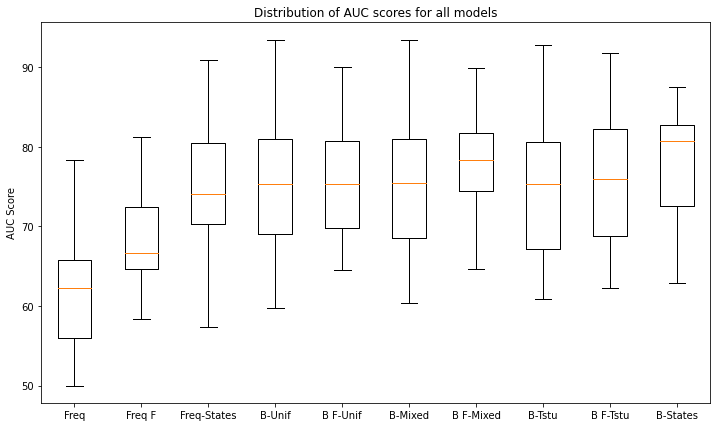

In [ ]:
fig = plt.figure(figsize =(12, 7))
 
plt.boxplot(boxplot_data.values, labels = ['Freq', 'Freq F','Freq-States', 'B-Unif','B F-Unif', 'B-Mixed', 'B F-Mixed', 'B-Tstu', 'B F-Tstu','B-States'])
plt.ylabel('AUC Score')
plt.title('Distribution of AUC scores for all models')

In [ ]:
boxplot_data

,Freq,Freq F,Freq-States,B-Unif,B F-Unif,B-Mixed,B F-Mixed,B-Tstu,B F-Tstu,B-States
0,57.5,65.9,65.5,69.0,75.4,68.7,79.0,75.4,69.6,72.6
1,70.0,62.8,74.1,79.4,73.9,76.1,72.3,77.7,71.9,84.6
2,78.3,81.2,70.3,93.5,82.1,93.5,89.9,92.8,91.8,80.7
3,58.6,64.7,57.3,66.3,68.4,66.3,74.5,64.5,62.7,67.5
4,52.3,65.5,80.5,69.1,79.3,68.6,68.6,73.2,82.0,82.7
5,65.8,72.5,77.5,79.4,75.2,80.8,83.3,78.3,83.3,87.5
6,64.7,68.7,90.9,81.0,86.7,81.0,80.4,80.6,85.7,77.4
7,56.0,66.7,70.3,59.7,64.5,60.4,64.7,60.9,65.7,72.0
8,56.9,73.7,84.1,79.6,81.8,78.6,77.3,83.1,79.2,81.6
9,62.3,73.7,84.4,75.3,73.3,75.3,81.8,73.3,78.7,85.4
